In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [5]:
from utils import Logger

In [47]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [20]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [48]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [37]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [38]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [39]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [40]:
loss = nn.BCELoss()

In [41]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [42]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [43]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [44]:
num_test_samples = 16
test_noise = noise(num_test_samples)

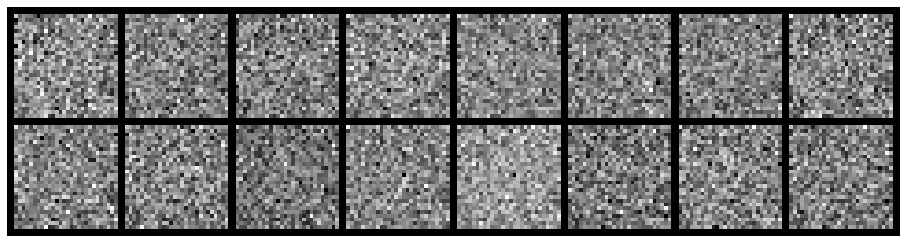

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.4009, Generator Loss: 0.6862
D(x): 0.4959, D(G(z)): 0.5030


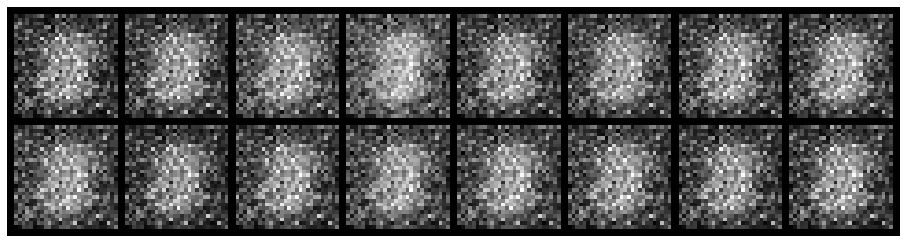

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.9195, Generator Loss: 1.0359
D(x): 0.4069, D(G(z)): 0.5527


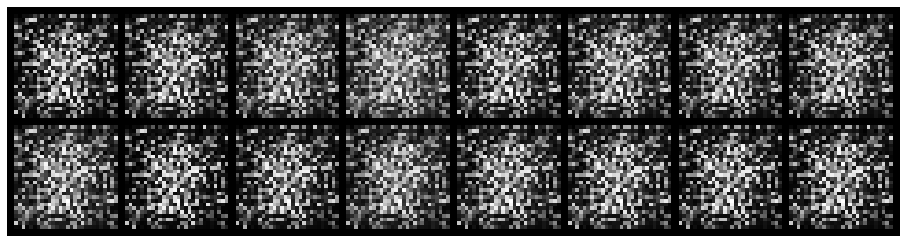

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.8303, Generator Loss: 2.6798
D(x): 0.8366, D(G(z)): 0.4257


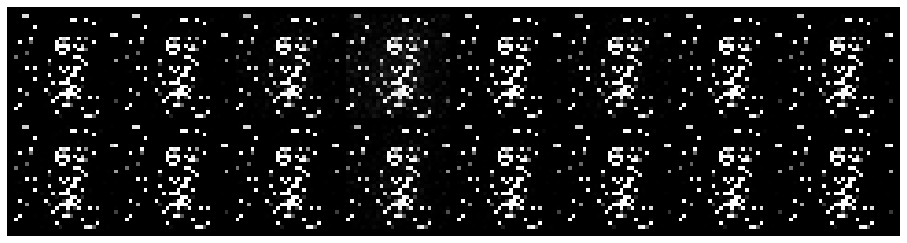

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0181, Generator Loss: 6.6778
D(x): 0.9930, D(G(z)): 0.0106


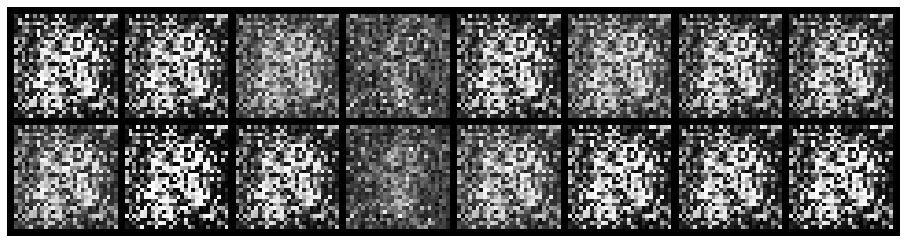

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.1305, Generator Loss: 5.2207
D(x): 0.9671, D(G(z)): 0.0819


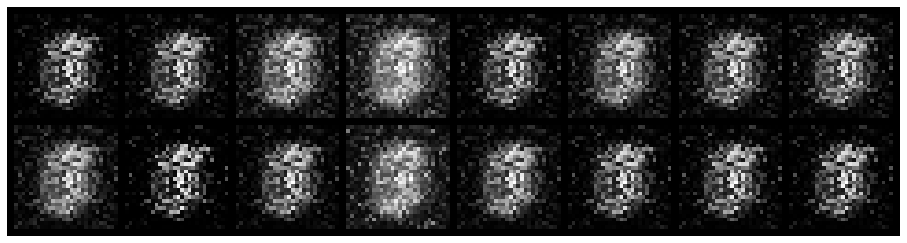

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.2659, Generator Loss: 1.7509
D(x): 0.5851, D(G(z)): 0.3657


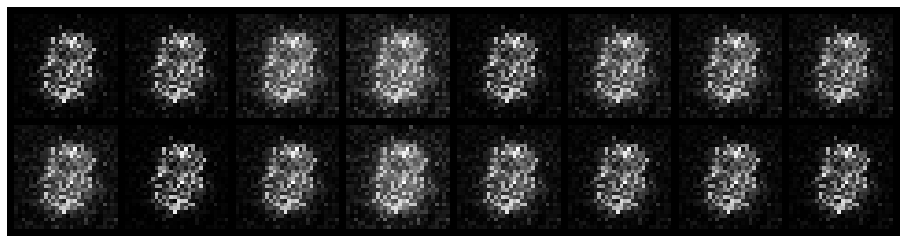

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 1.3773, Generator Loss: 1.5855
D(x): 0.5688, D(G(z)): 0.3647


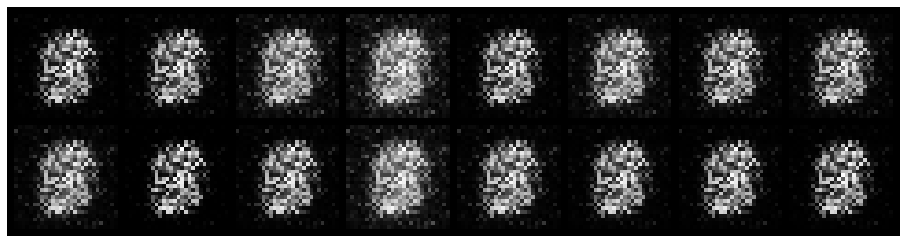

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.4760, Generator Loss: 3.3644
D(x): 0.8044, D(G(z)): 0.1916


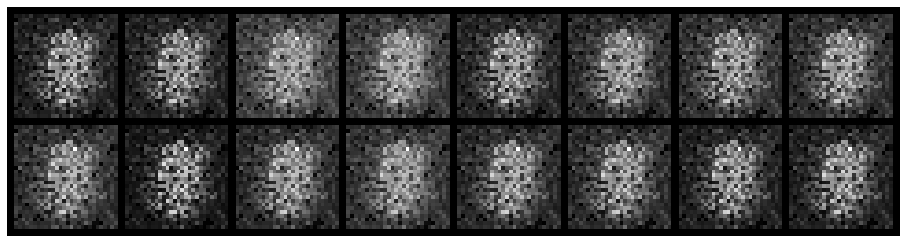

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.5054, Generator Loss: 2.1843
D(x): 0.7949, D(G(z)): 0.2157


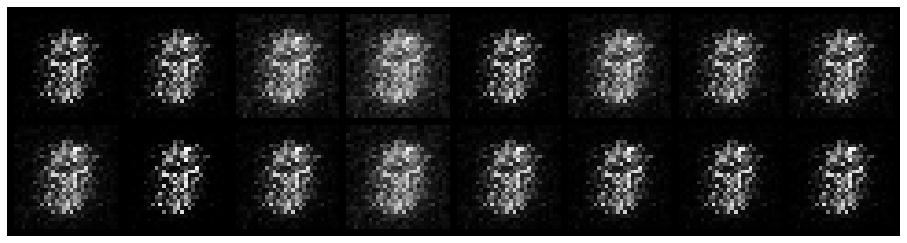

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.6062, Generator Loss: 2.0955
D(x): 0.7315, D(G(z)): 0.1960


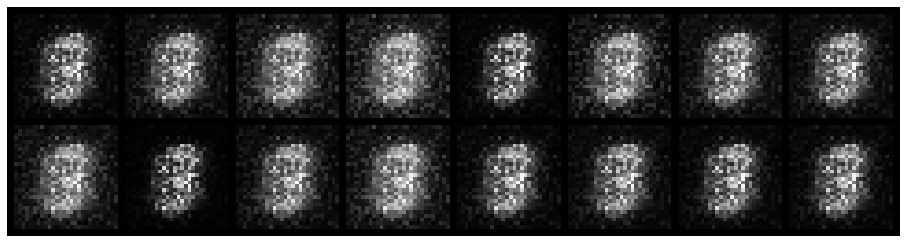

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 1.2985, Generator Loss: 2.5074
D(x): 0.6993, D(G(z)): 0.4621


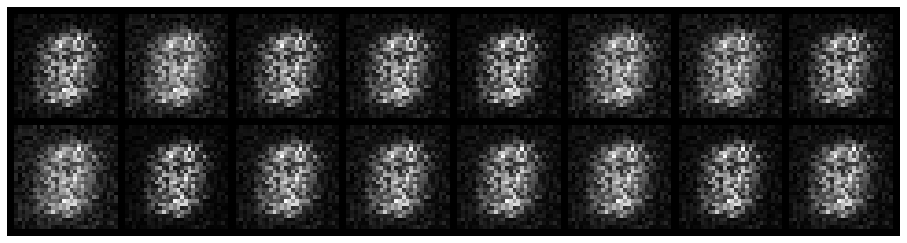

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 1.5947, Generator Loss: 1.5221
D(x): 0.5367, D(G(z)): 0.4059


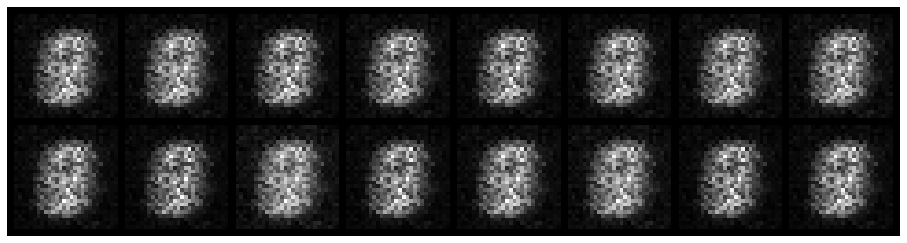

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.4619, Generator Loss: 2.8364
D(x): 0.8129, D(G(z)): 0.1857


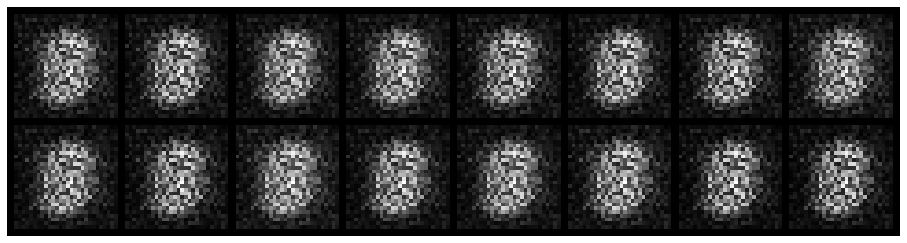

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.2061, Generator Loss: 4.4805
D(x): 0.9479, D(G(z)): 0.1187


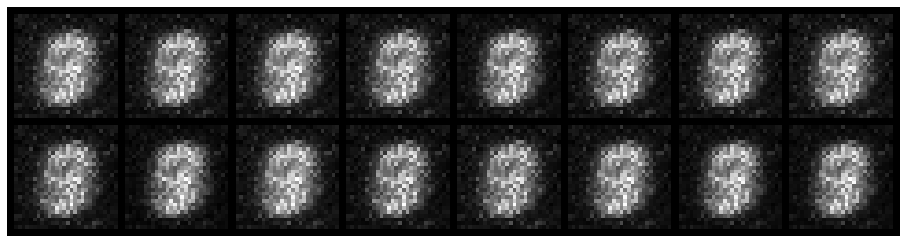

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 1.0680, Generator Loss: 1.0689
D(x): 0.6671, D(G(z)): 0.3933


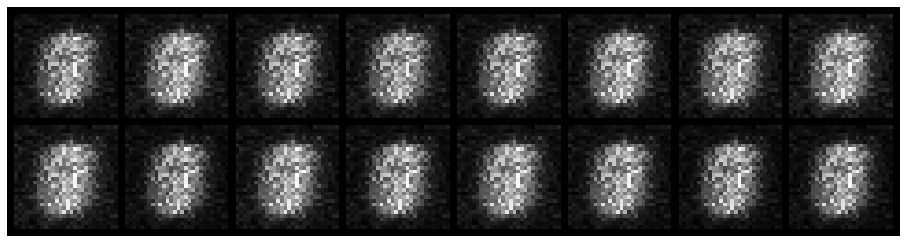

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.4792, Generator Loss: 1.0882
D(x): 0.6340, D(G(z)): 0.4969


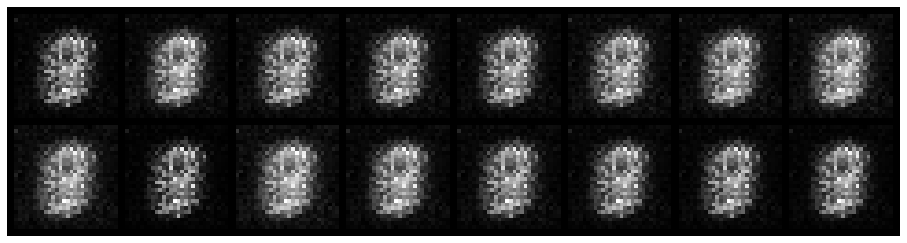

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.6411, Generator Loss: 3.5272
D(x): 0.7988, D(G(z)): 0.2121


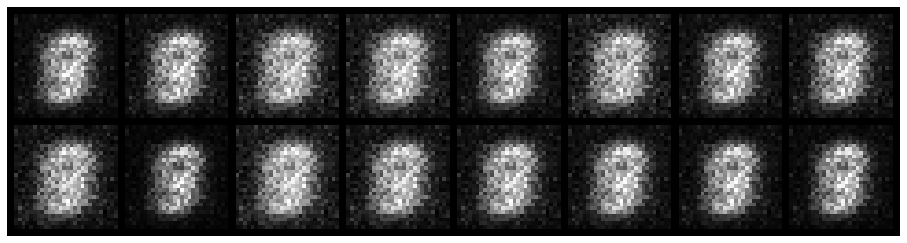

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.7121, Generator Loss: 2.2954
D(x): 0.7925, D(G(z)): 0.2849


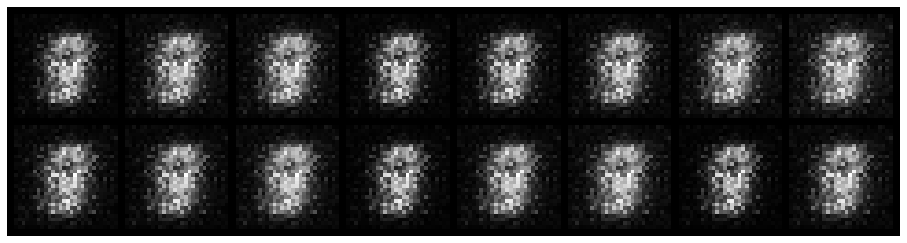

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.5325, Generator Loss: 2.5299
D(x): 0.8215, D(G(z)): 0.1750


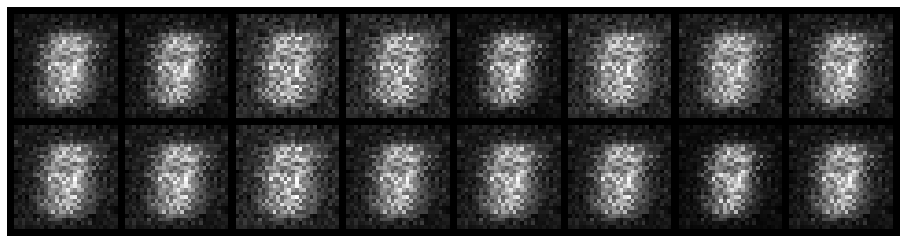

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.3633, Generator Loss: 2.2938
D(x): 0.9022, D(G(z)): 0.1748


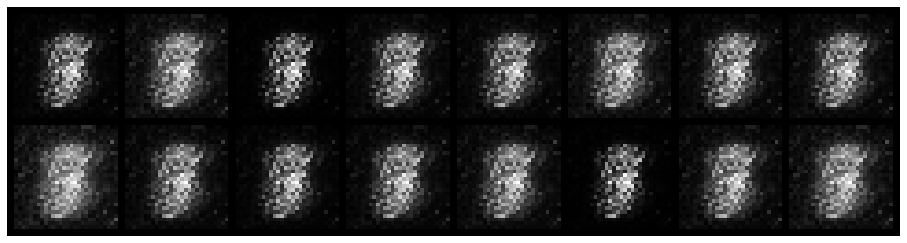

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.1157, Generator Loss: 4.1275
D(x): 0.9524, D(G(z)): 0.0430


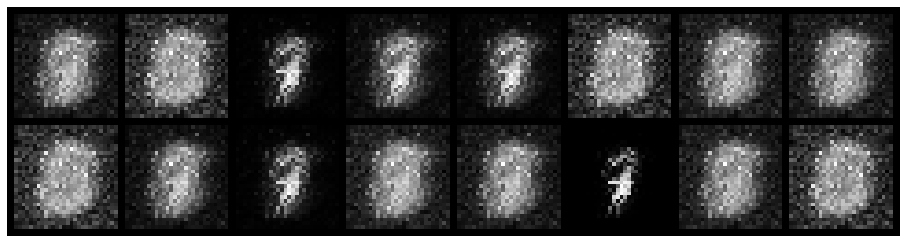

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.4329, Generator Loss: 4.1627
D(x): 0.8253, D(G(z)): 0.0928


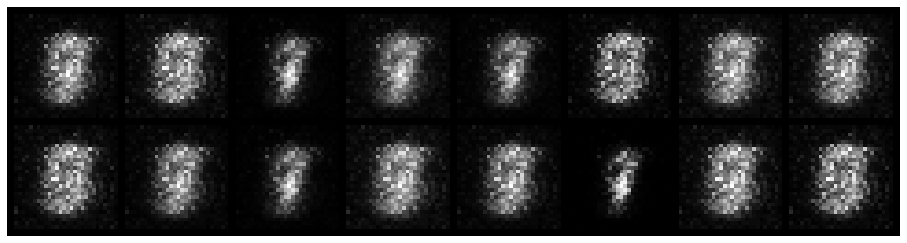

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.5947, Generator Loss: 2.9347
D(x): 0.8351, D(G(z)): 0.1357


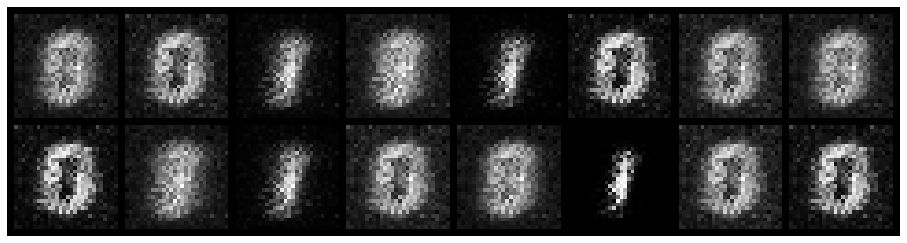

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.6069, Generator Loss: 2.8636
D(x): 0.8122, D(G(z)): 0.1363


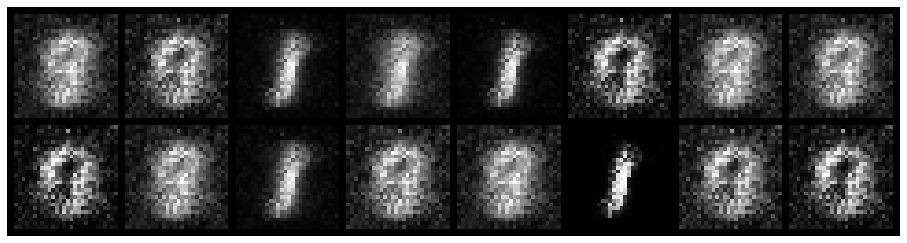

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.4216, Generator Loss: 3.2604
D(x): 0.8737, D(G(z)): 0.1540


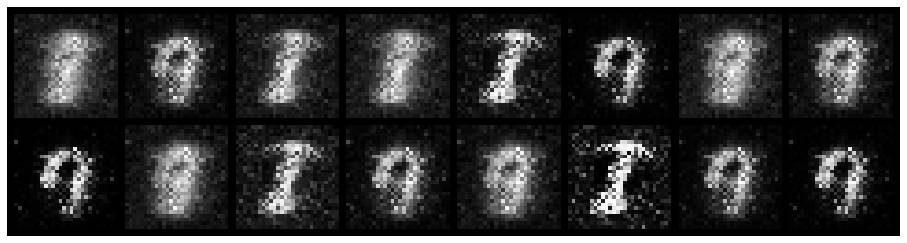

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.8235, Generator Loss: 1.5263
D(x): 0.8251, D(G(z)): 0.2109


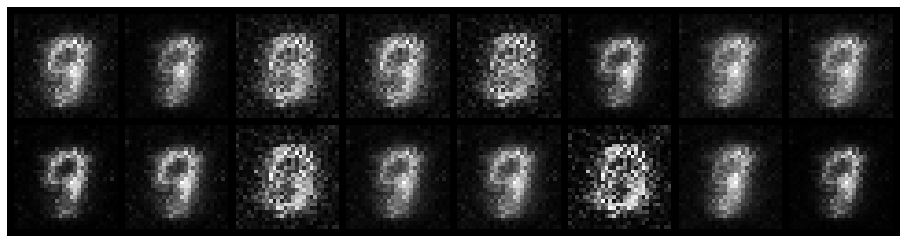

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.5777, Generator Loss: 2.3514
D(x): 0.8394, D(G(z)): 0.1946


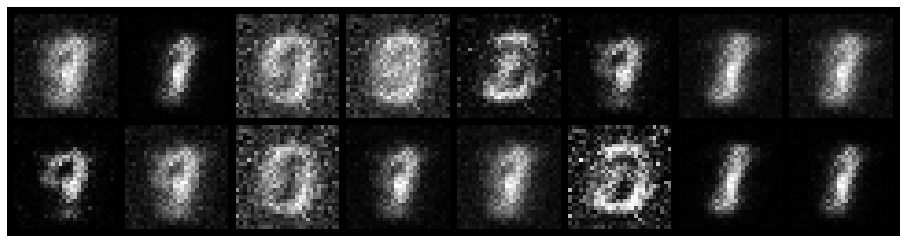

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.6023, Generator Loss: 3.3042
D(x): 0.8565, D(G(z)): 0.1650


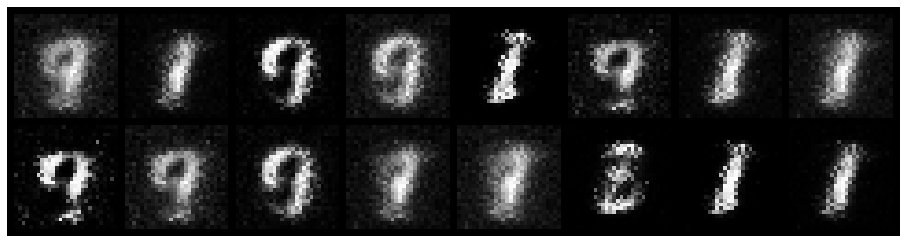

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.6539, Generator Loss: 2.0349
D(x): 0.8439, D(G(z)): 0.2486


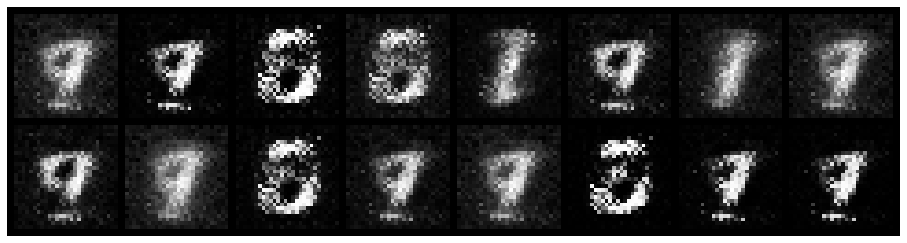

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.6364, Generator Loss: 2.9291
D(x): 0.8553, D(G(z)): 0.1892


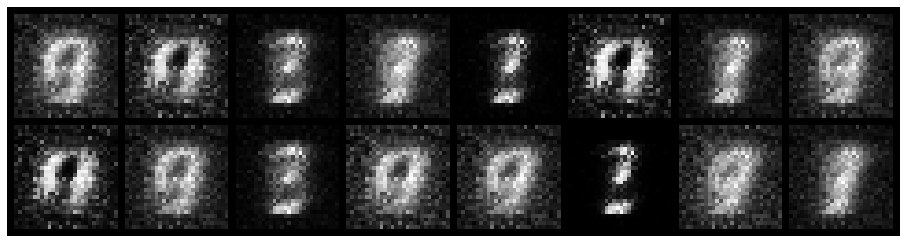

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.4922, Generator Loss: 3.1560
D(x): 0.8693, D(G(z)): 0.1372


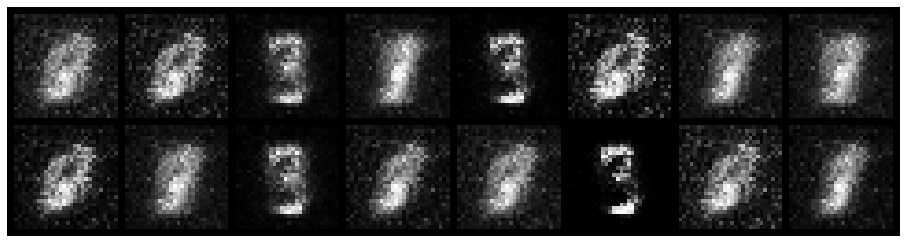

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.3320, Generator Loss: 3.3262
D(x): 0.8858, D(G(z)): 0.0803


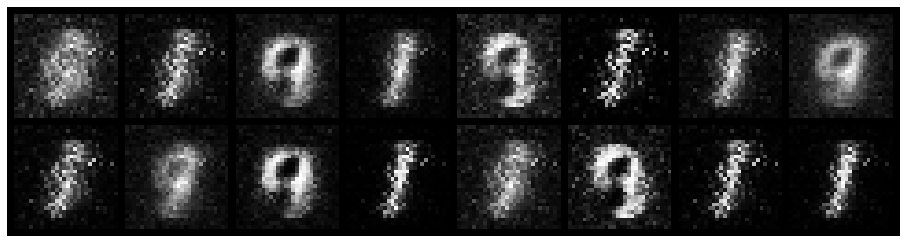

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.3752, Generator Loss: 3.0820
D(x): 0.9318, D(G(z)): 0.1734


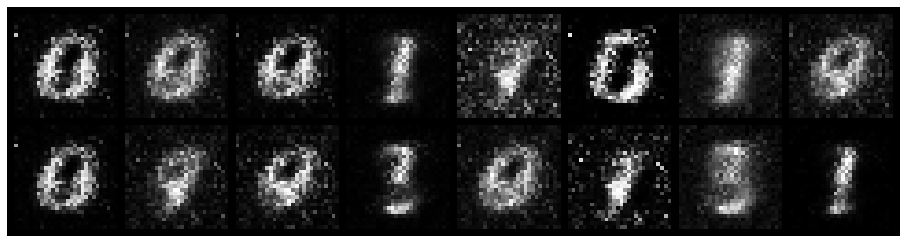

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.4812, Generator Loss: 2.9669
D(x): 0.8403, D(G(z)): 0.1371


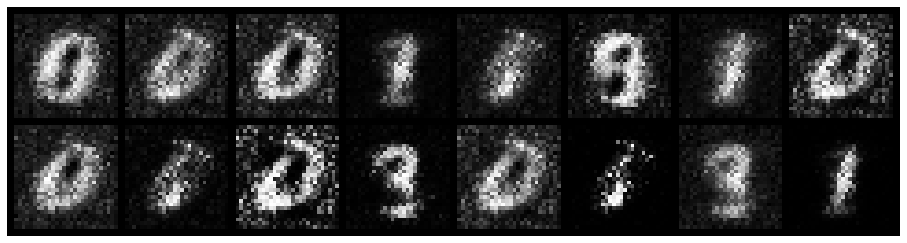

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.4122, Generator Loss: 3.5827
D(x): 0.8580, D(G(z)): 0.0670


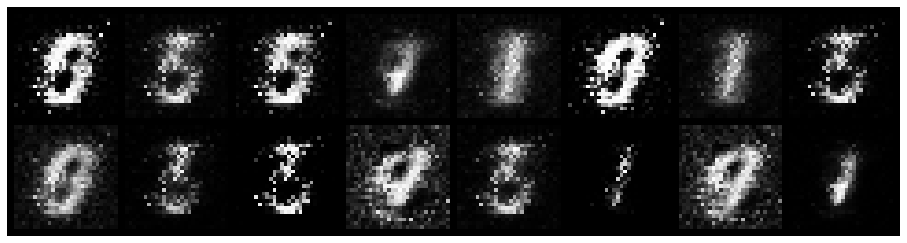

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.4336, Generator Loss: 3.3799
D(x): 0.8669, D(G(z)): 0.1419


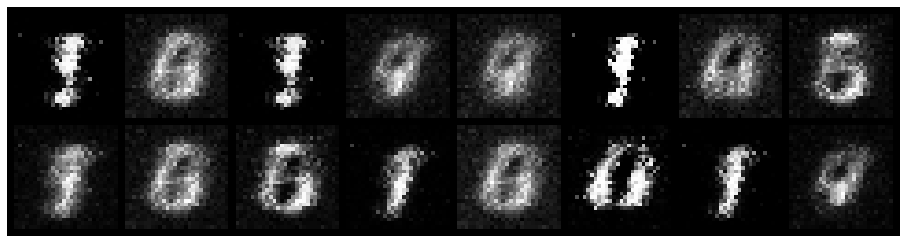

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.3692, Generator Loss: 3.0361
D(x): 0.8649, D(G(z)): 0.1272


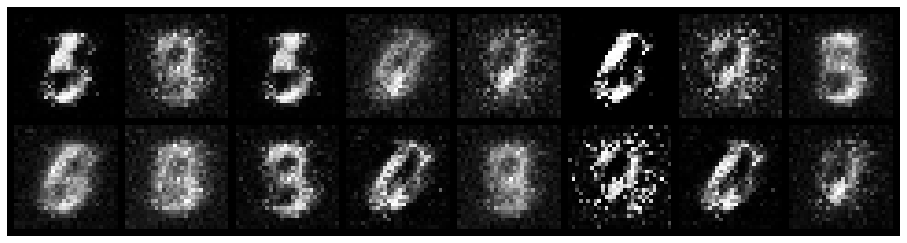

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.3594, Generator Loss: 2.3642
D(x): 0.9011, D(G(z)): 0.1362


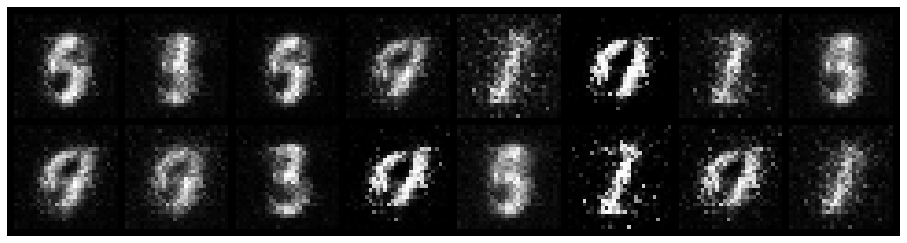

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.5547, Generator Loss: 2.3869
D(x): 0.8973, D(G(z)): 0.2531


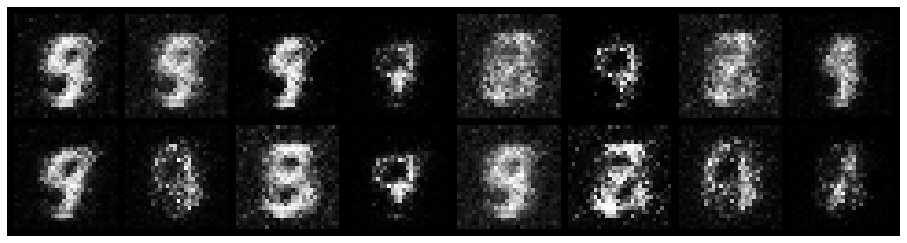

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.6376, Generator Loss: 3.8860
D(x): 0.8184, D(G(z)): 0.1539


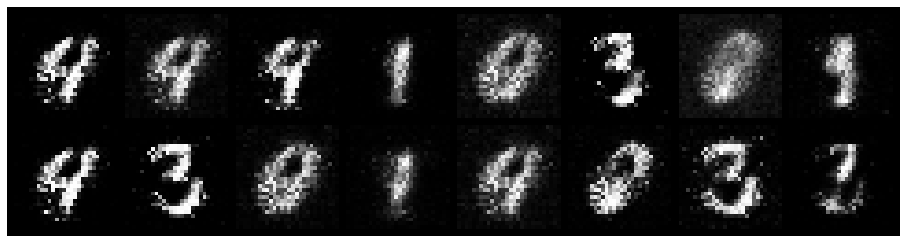

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.3928, Generator Loss: 2.9911
D(x): 0.8762, D(G(z)): 0.1193


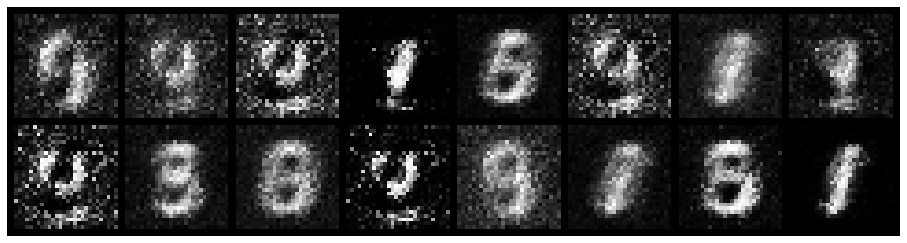

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.6492, Generator Loss: 1.8302
D(x): 0.8662, D(G(z)): 0.2625


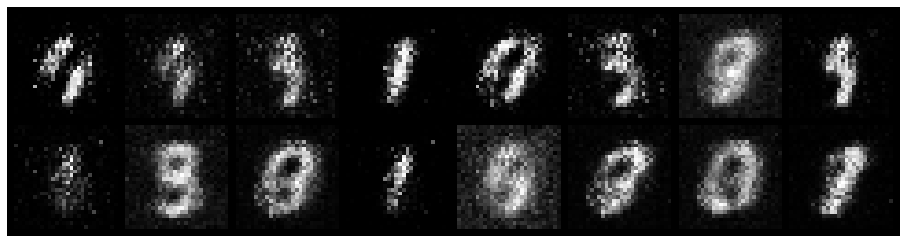

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.4011, Generator Loss: 2.4193
D(x): 0.8757, D(G(z)): 0.1348


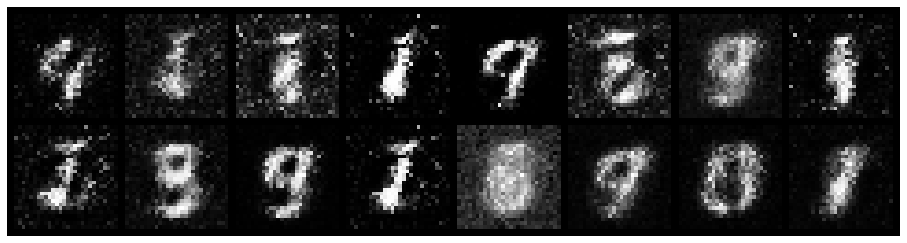

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.4345, Generator Loss: 2.8557
D(x): 0.9119, D(G(z)): 0.1466


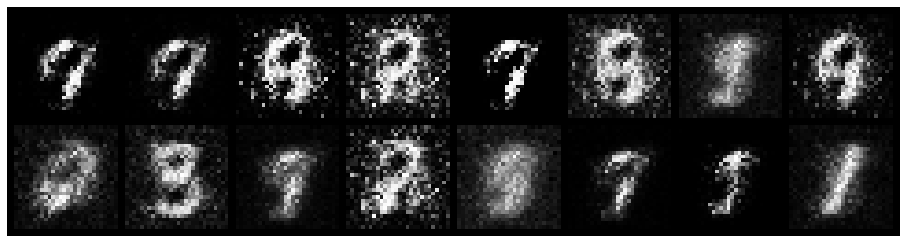

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.3717, Generator Loss: 2.8155
D(x): 0.8803, D(G(z)): 0.1541


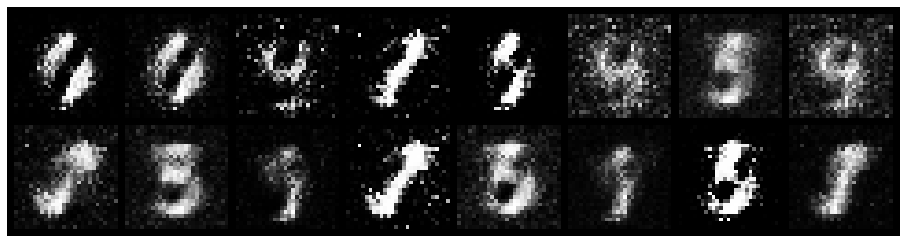

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.5303, Generator Loss: 2.3089
D(x): 0.8454, D(G(z)): 0.1711


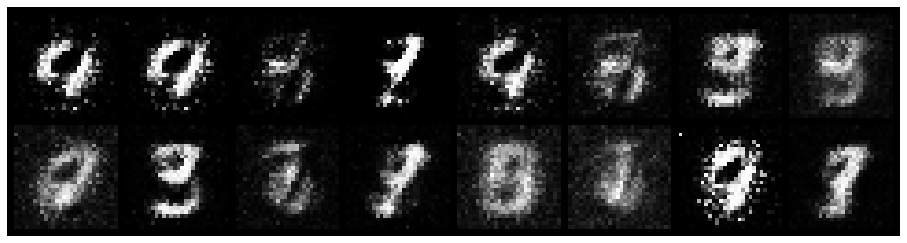

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.5366, Generator Loss: 2.2728
D(x): 0.8405, D(G(z)): 0.2058


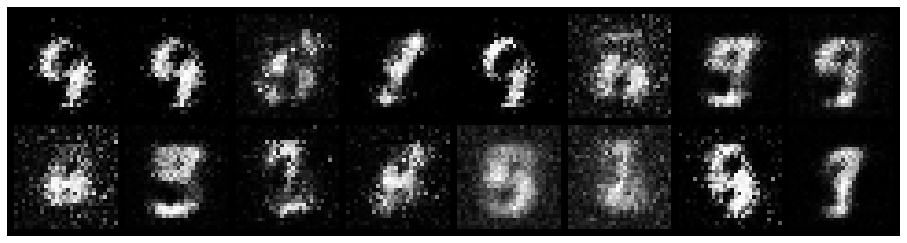

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.5455, Generator Loss: 2.6313
D(x): 0.8130, D(G(z)): 0.1838


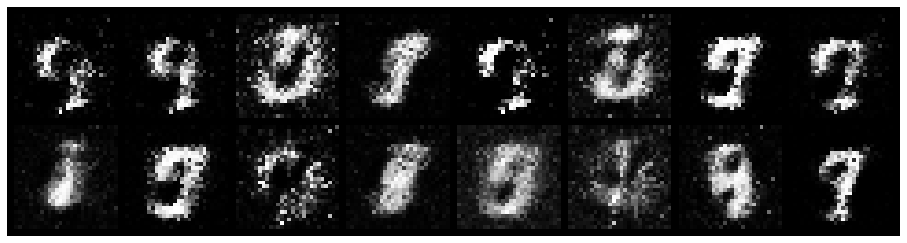

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.7244, Generator Loss: 2.1206
D(x): 0.7943, D(G(z)): 0.2626


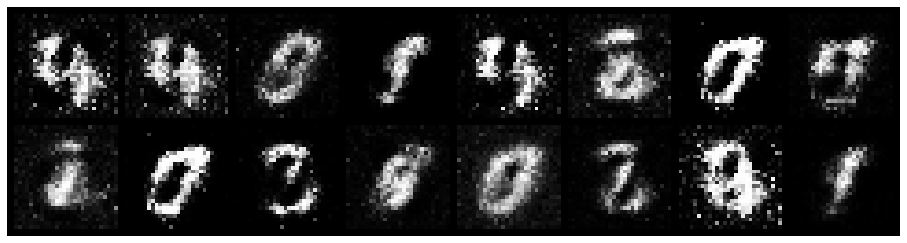

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.6014, Generator Loss: 2.9253
D(x): 0.8625, D(G(z)): 0.2239


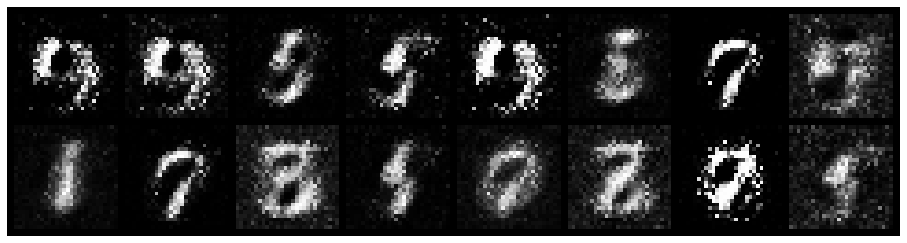

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.6822, Generator Loss: 2.8839
D(x): 0.7596, D(G(z)): 0.1829


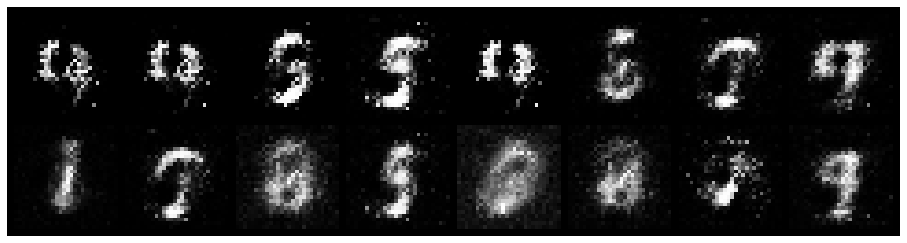

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.3433, Generator Loss: 2.1715
D(x): 0.8848, D(G(z)): 0.1196


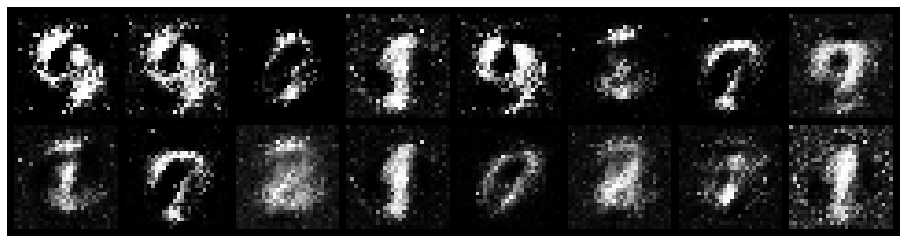

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.4072, Generator Loss: 3.1532
D(x): 0.9116, D(G(z)): 0.1476


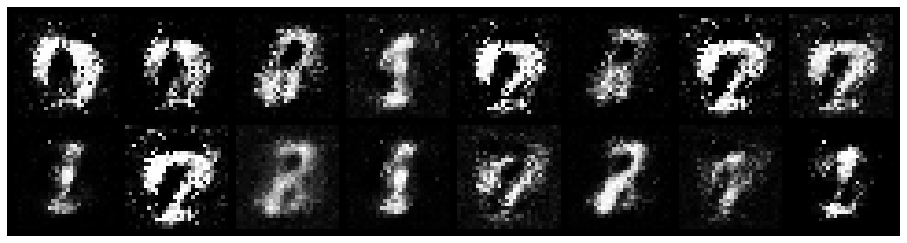

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.6006, Generator Loss: 4.1280
D(x): 0.8308, D(G(z)): 0.1181


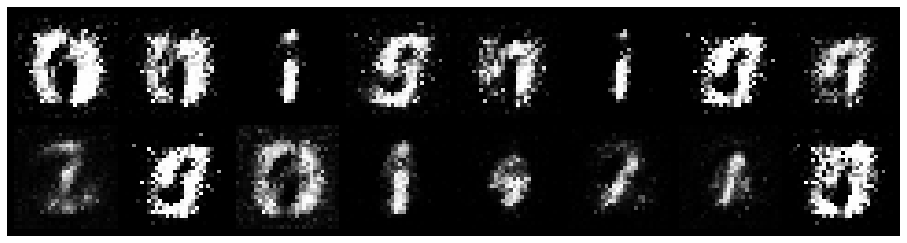

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.6776, Generator Loss: 2.5177
D(x): 0.8008, D(G(z)): 0.1822


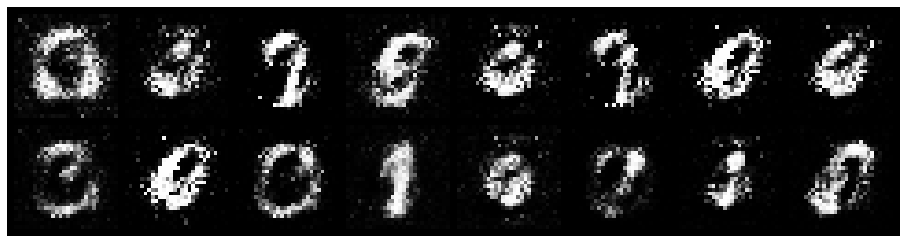

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.7524, Generator Loss: 2.1803
D(x): 0.8396, D(G(z)): 0.3061


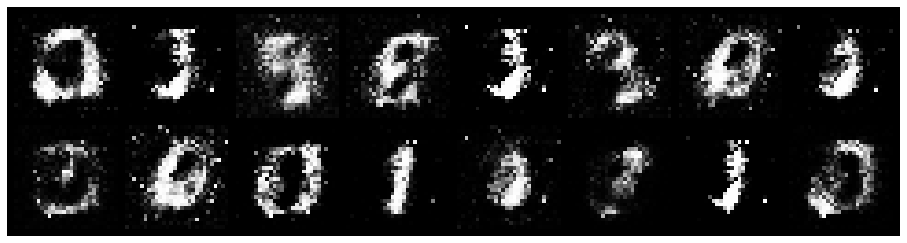

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.7632, Generator Loss: 2.4990
D(x): 0.8186, D(G(z)): 0.2866


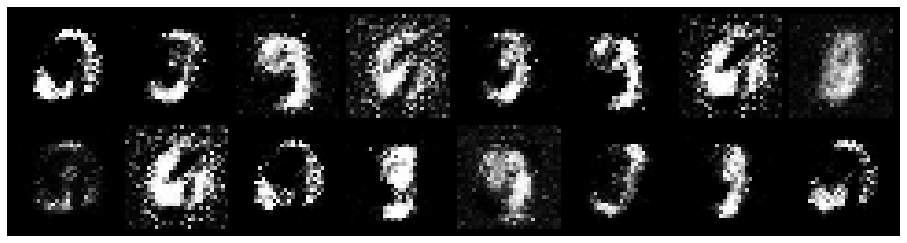

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.5388, Generator Loss: 2.2177
D(x): 0.8820, D(G(z)): 0.2119


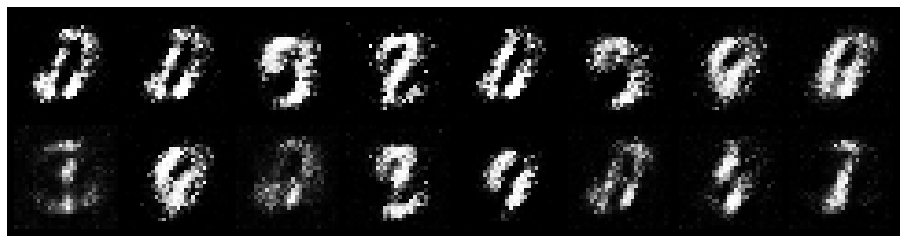

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.7051, Generator Loss: 2.3809
D(x): 0.9180, D(G(z)): 0.3272


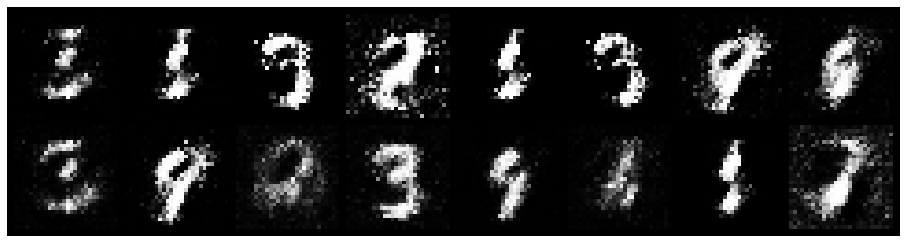

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.8712, Generator Loss: 2.7345
D(x): 0.7286, D(G(z)): 0.1693


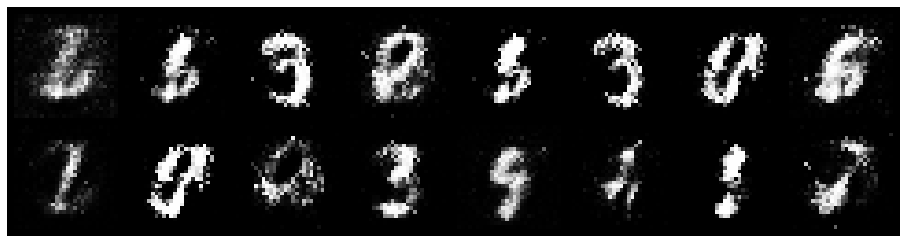

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.4790, Generator Loss: 3.2928
D(x): 0.8345, D(G(z)): 0.1095


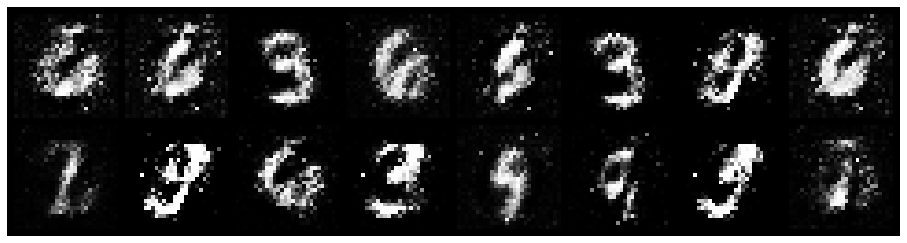

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.3837, Generator Loss: 2.9442
D(x): 0.8545, D(G(z)): 0.1136


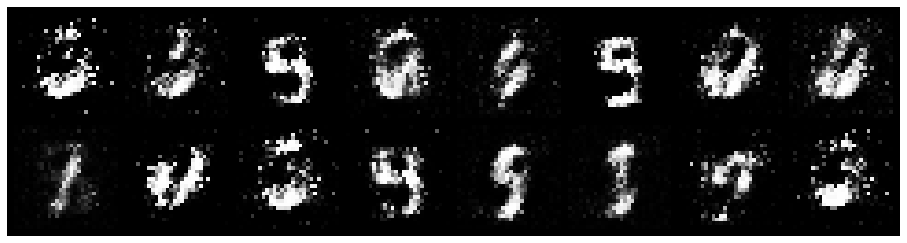

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.7564, Generator Loss: 2.2295
D(x): 0.7701, D(G(z)): 0.2076


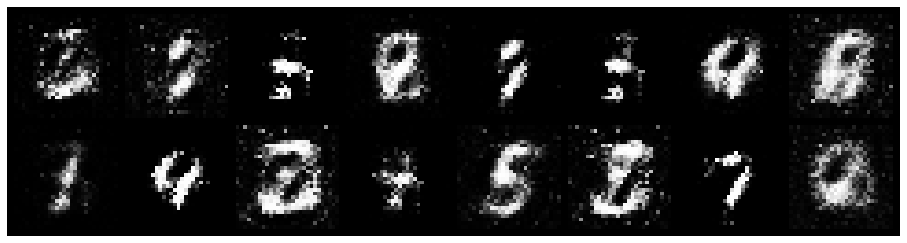

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.5807, Generator Loss: 3.0487
D(x): 0.7948, D(G(z)): 0.1418


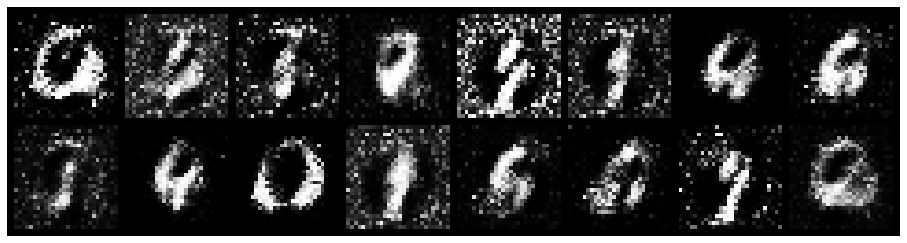

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.6346, Generator Loss: 2.5873
D(x): 0.7782, D(G(z)): 0.1489


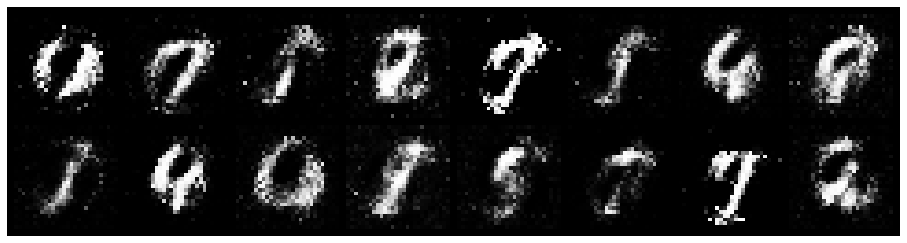

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.5961, Generator Loss: 2.3150
D(x): 0.8369, D(G(z)): 0.2088


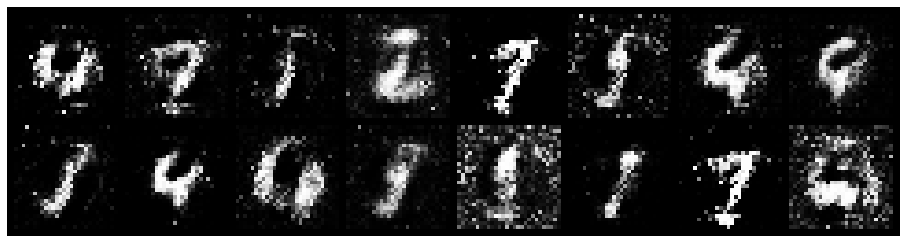

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.7269, Generator Loss: 2.5297
D(x): 0.7436, D(G(z)): 0.1774


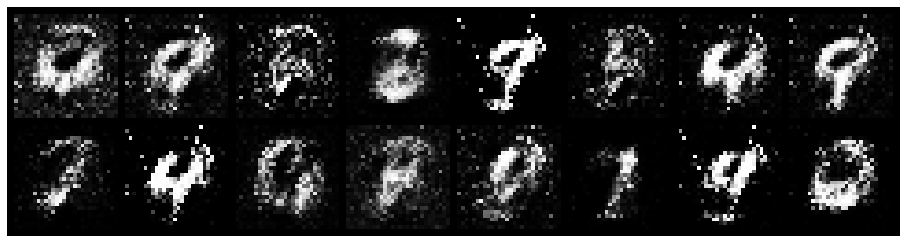

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.7153, Generator Loss: 2.3849
D(x): 0.7244, D(G(z)): 0.1732


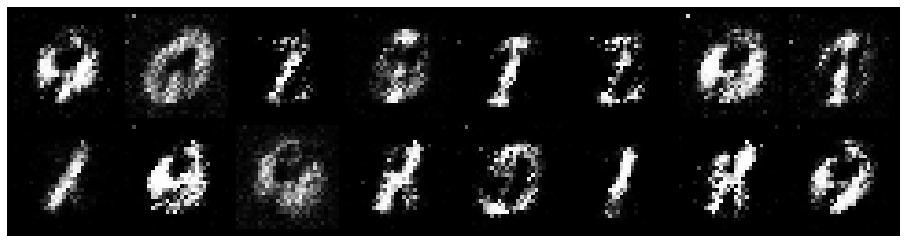

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.6510, Generator Loss: 2.0863
D(x): 0.8422, D(G(z)): 0.2753


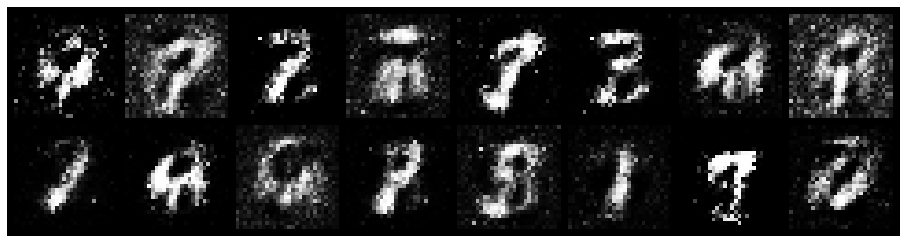

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.7813, Generator Loss: 2.3053
D(x): 0.7524, D(G(z)): 0.2324


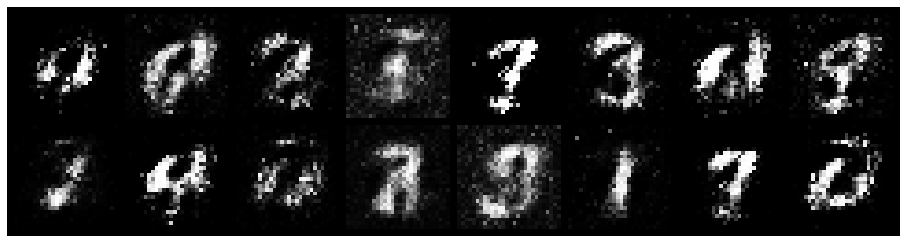

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.8337, Generator Loss: 2.1274
D(x): 0.7790, D(G(z)): 0.2726


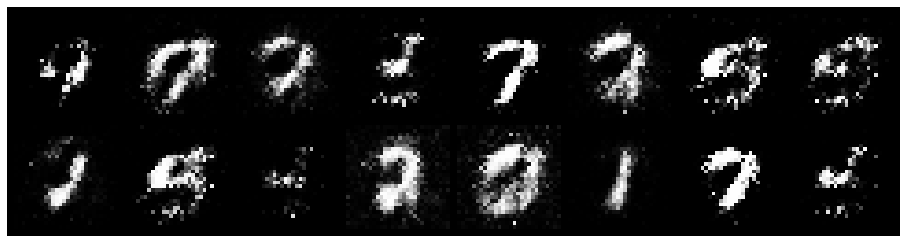

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.5677, Generator Loss: 2.4184
D(x): 0.8304, D(G(z)): 0.1994


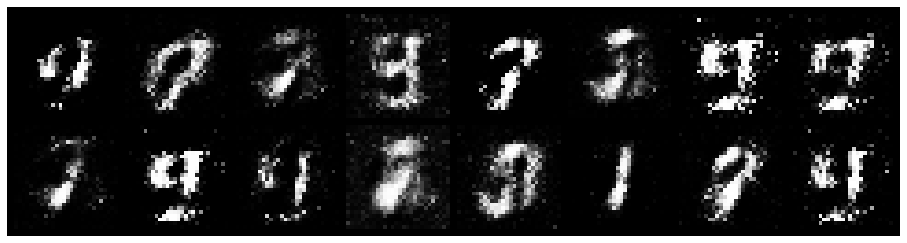

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.7442, Generator Loss: 1.9313
D(x): 0.8593, D(G(z)): 0.3113


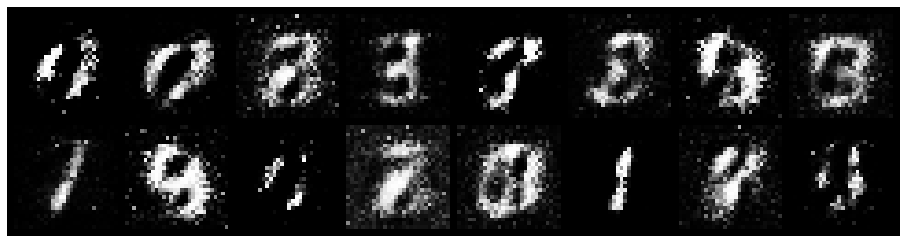

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.6514, Generator Loss: 2.0504
D(x): 0.8550, D(G(z)): 0.2903


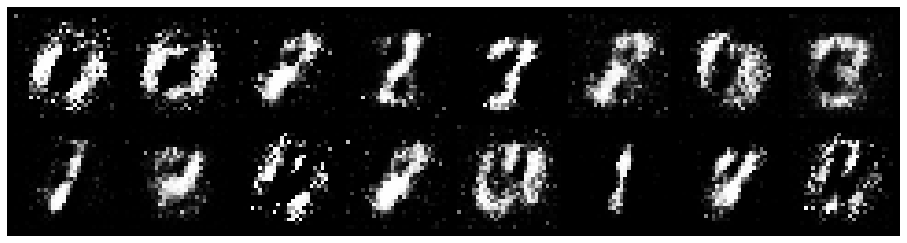

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.6022, Generator Loss: 2.2349
D(x): 0.8339, D(G(z)): 0.2618


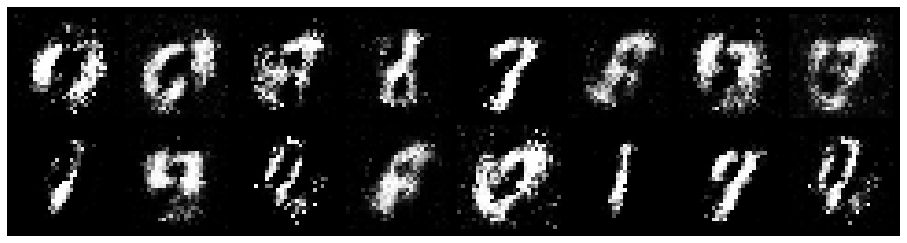

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.7092, Generator Loss: 1.9754
D(x): 0.7465, D(G(z)): 0.2088


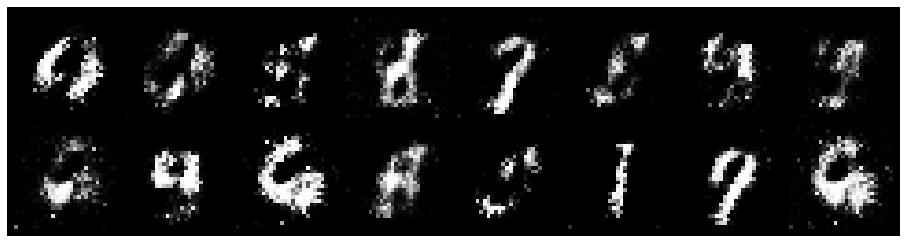

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.6327, Generator Loss: 2.0993
D(x): 0.8285, D(G(z)): 0.2513


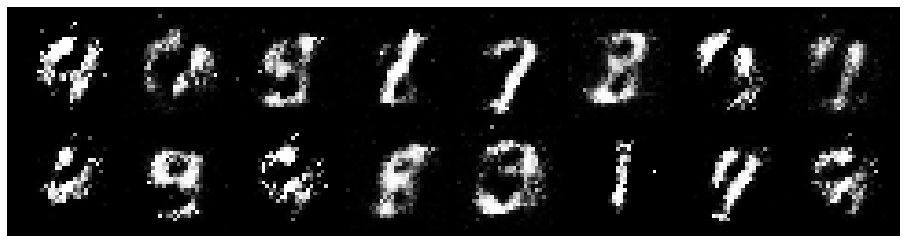

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.5684, Generator Loss: 2.3609
D(x): 0.8055, D(G(z)): 0.1540


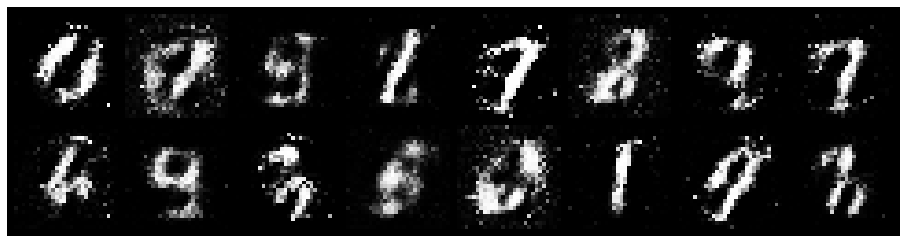

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.6706, Generator Loss: 2.3050
D(x): 0.7481, D(G(z)): 0.1809


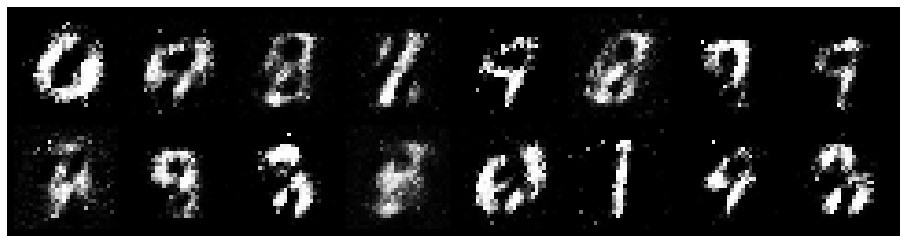

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.6745, Generator Loss: 2.4190
D(x): 0.7766, D(G(z)): 0.1620


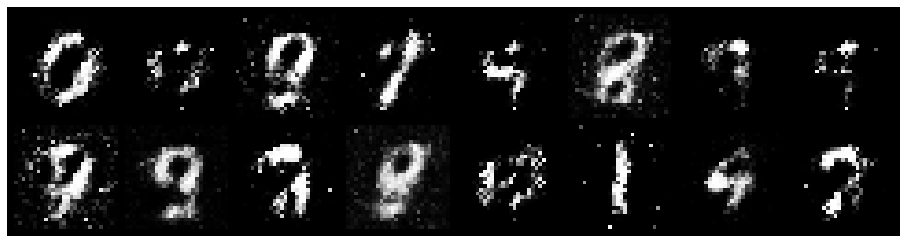

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.7777, Generator Loss: 2.4117
D(x): 0.6890, D(G(z)): 0.1228


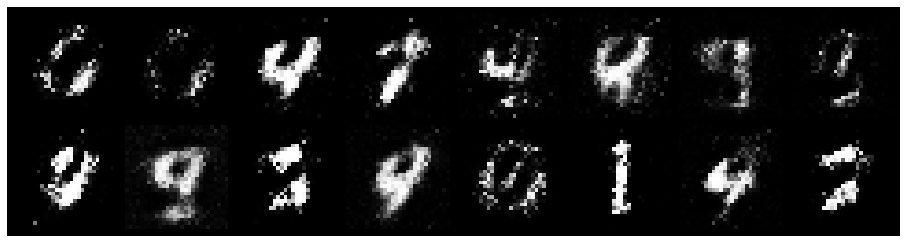

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 1.0305, Generator Loss: 1.9968
D(x): 0.7128, D(G(z)): 0.2587


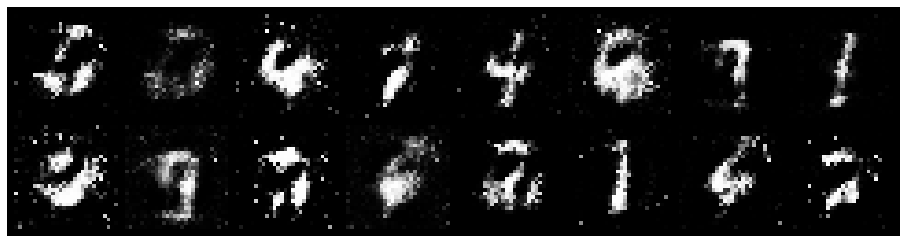

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.9900, Generator Loss: 2.1052
D(x): 0.8013, D(G(z)): 0.3222


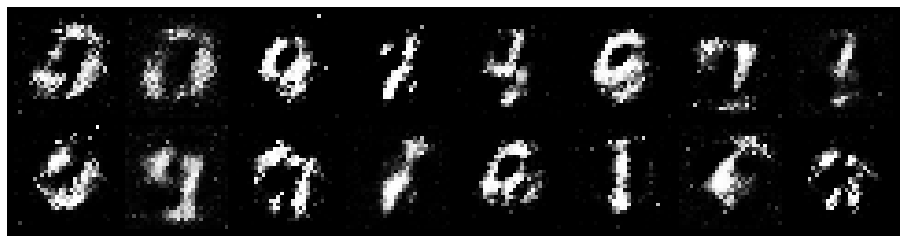

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.8690, Generator Loss: 2.1862
D(x): 0.6821, D(G(z)): 0.1646


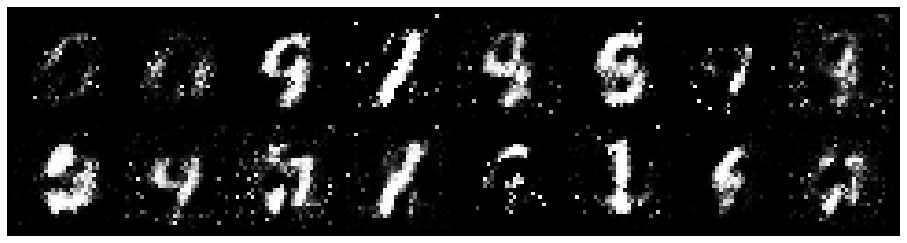

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.6115, Generator Loss: 2.8578
D(x): 0.7718, D(G(z)): 0.1535


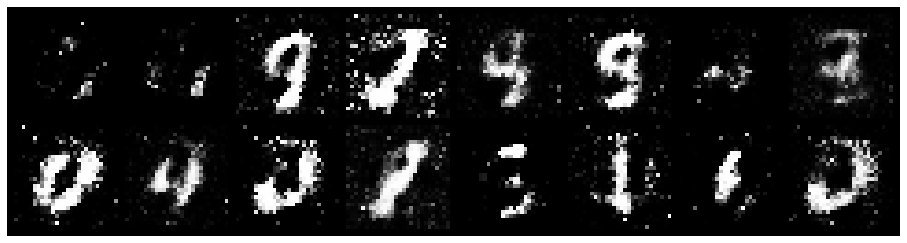

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.6266, Generator Loss: 2.7209
D(x): 0.8348, D(G(z)): 0.1940


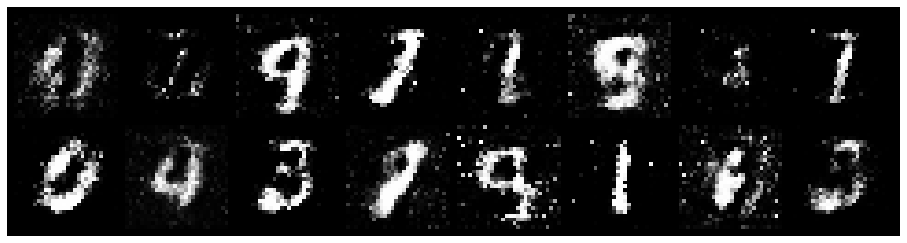

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.6284, Generator Loss: 2.9990
D(x): 0.7695, D(G(z)): 0.1709


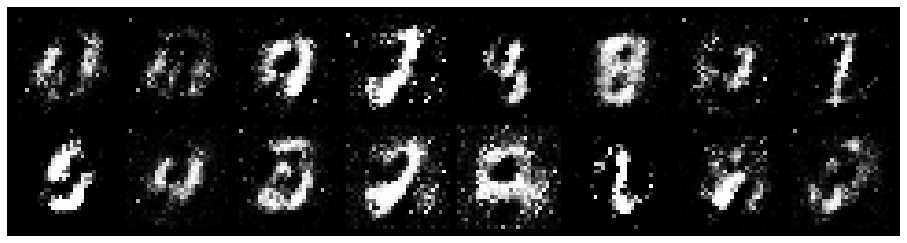

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.5526, Generator Loss: 3.0512
D(x): 0.8370, D(G(z)): 0.1700


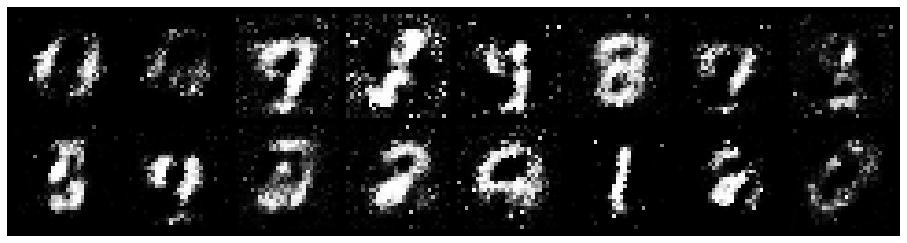

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.6378, Generator Loss: 2.5228
D(x): 0.7609, D(G(z)): 0.1822


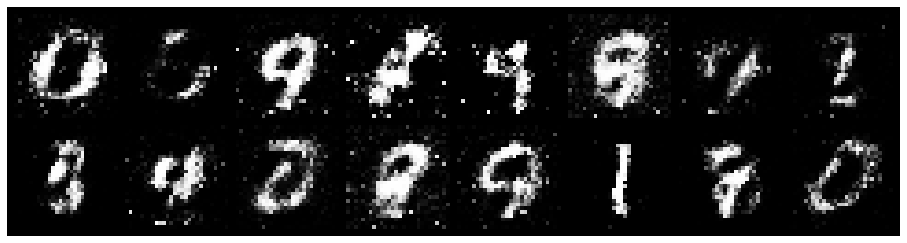

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.6237, Generator Loss: 2.9808
D(x): 0.8265, D(G(z)): 0.2035


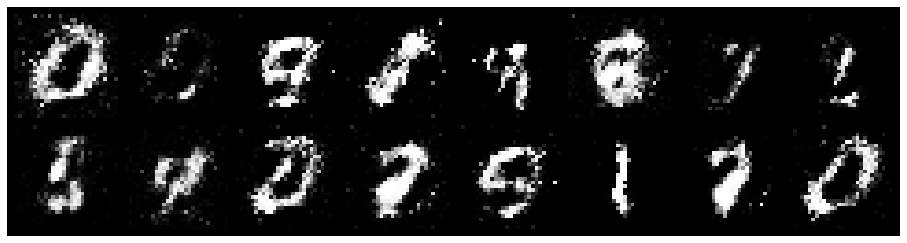

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.5926, Generator Loss: 2.9428
D(x): 0.8360, D(G(z)): 0.1744


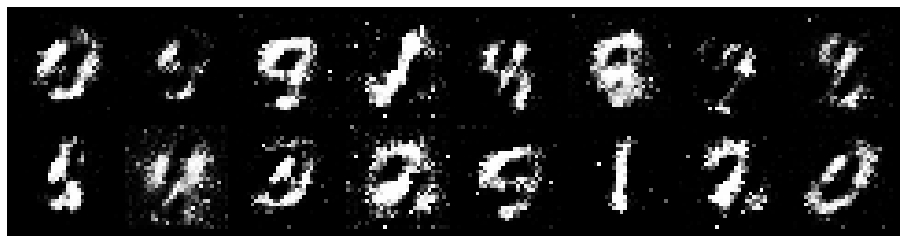

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.4398, Generator Loss: 2.8756
D(x): 0.8212, D(G(z)): 0.1255


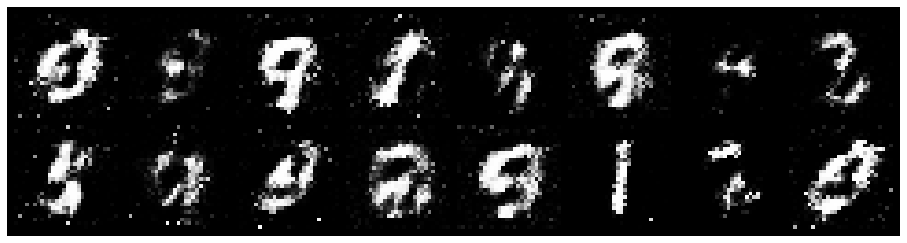

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.7408, Generator Loss: 2.3169
D(x): 0.8167, D(G(z)): 0.2994


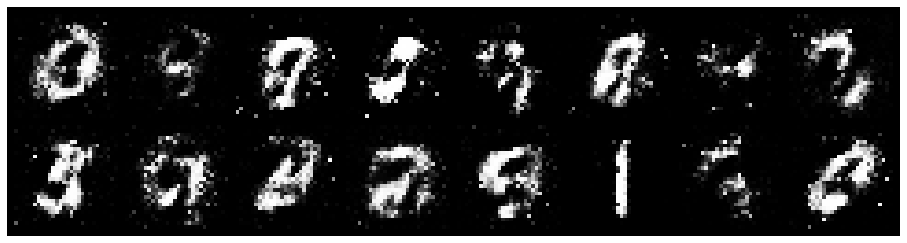

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.6004, Generator Loss: 2.9712
D(x): 0.7944, D(G(z)): 0.1879


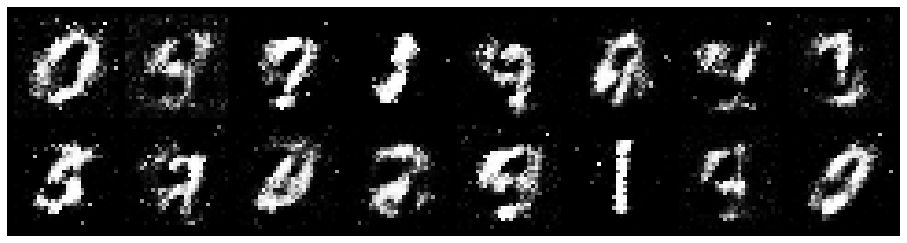

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.7171, Generator Loss: 2.4071
D(x): 0.7846, D(G(z)): 0.2324


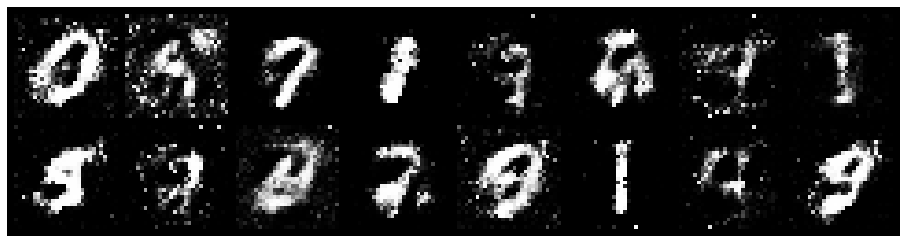

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.6229, Generator Loss: 2.4324
D(x): 0.7818, D(G(z)): 0.1844


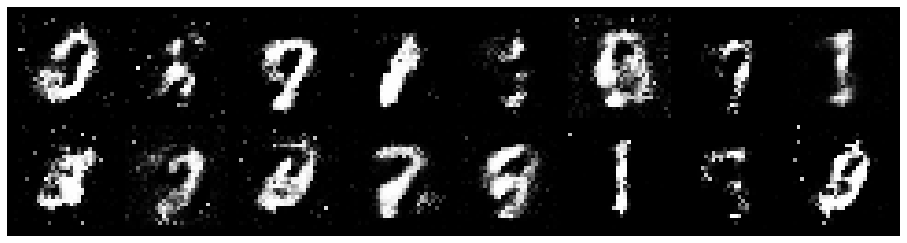

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 1.2546, Generator Loss: 1.5908
D(x): 0.6427, D(G(z)): 0.3649


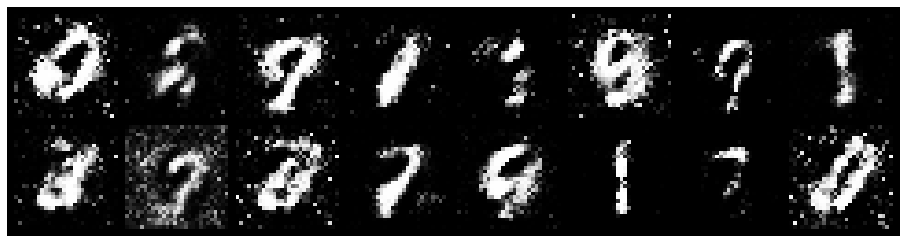

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 1.2122, Generator Loss: 1.5889
D(x): 0.6540, D(G(z)): 0.3408


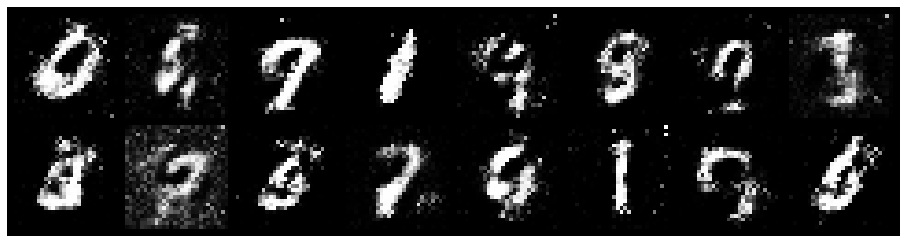

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.8091, Generator Loss: 1.8736
D(x): 0.7367, D(G(z)): 0.2469


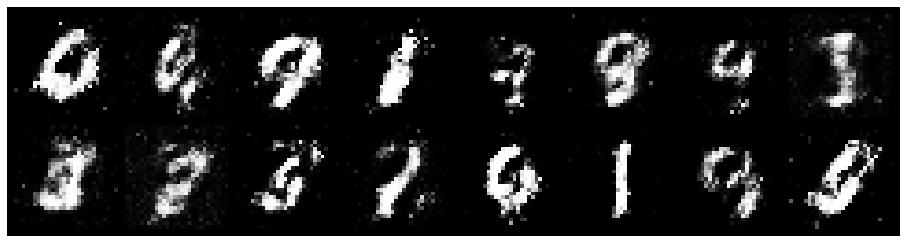

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.8206, Generator Loss: 2.2491
D(x): 0.6922, D(G(z)): 0.1633


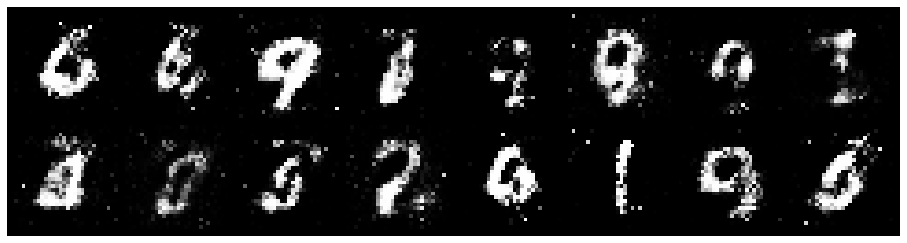

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.6736, Generator Loss: 2.6232
D(x): 0.7614, D(G(z)): 0.1954


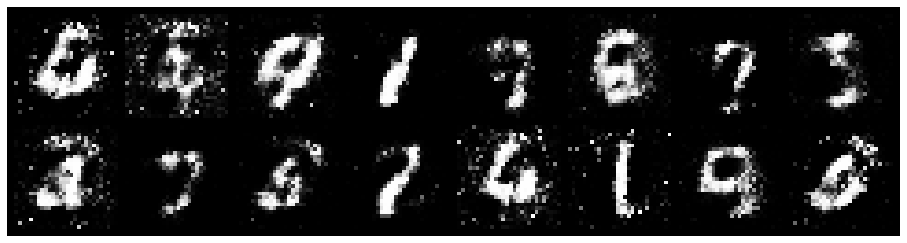

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.9897, Generator Loss: 2.5594
D(x): 0.7463, D(G(z)): 0.2872


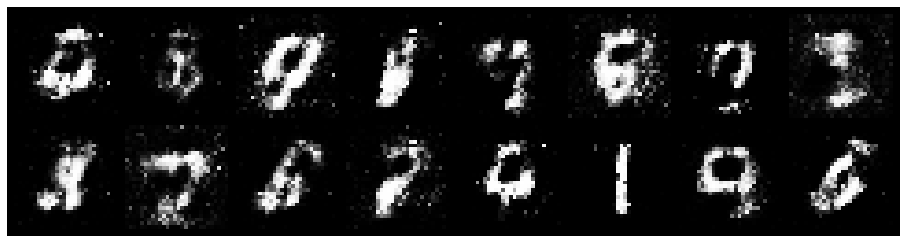

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.7552, Generator Loss: 1.6792
D(x): 0.7629, D(G(z)): 0.2441


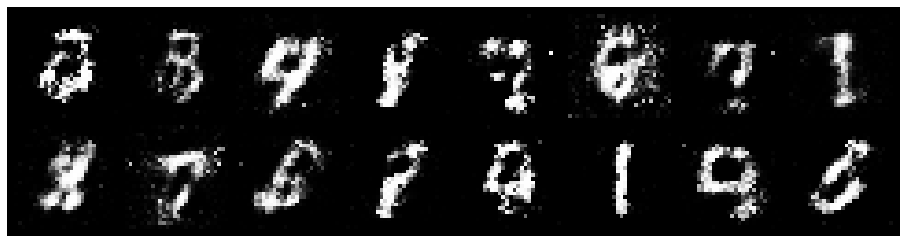

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.7593, Generator Loss: 1.7654
D(x): 0.7523, D(G(z)): 0.2575


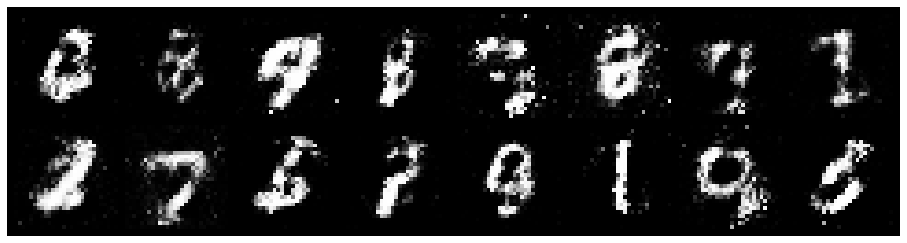

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.6778, Generator Loss: 1.9576
D(x): 0.8246, D(G(z)): 0.2712


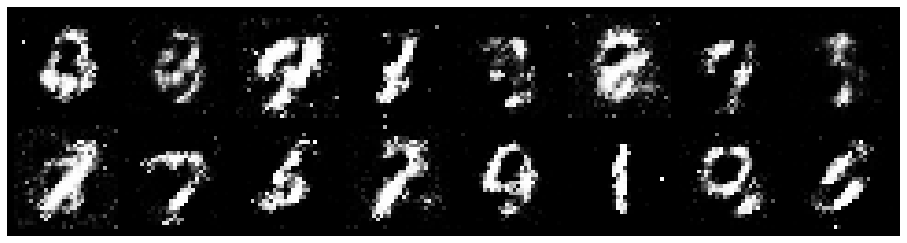

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.8258, Generator Loss: 1.7654
D(x): 0.7802, D(G(z)): 0.2769


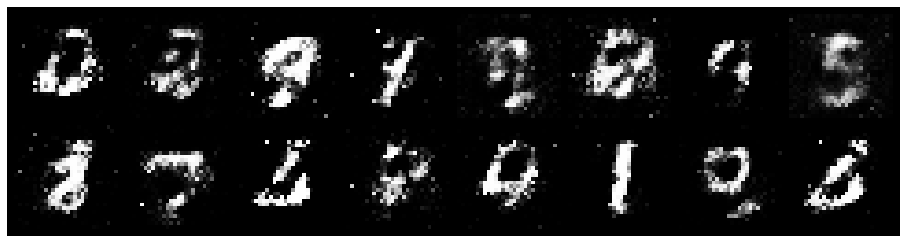

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.7304, Generator Loss: 1.9499
D(x): 0.7866, D(G(z)): 0.2673


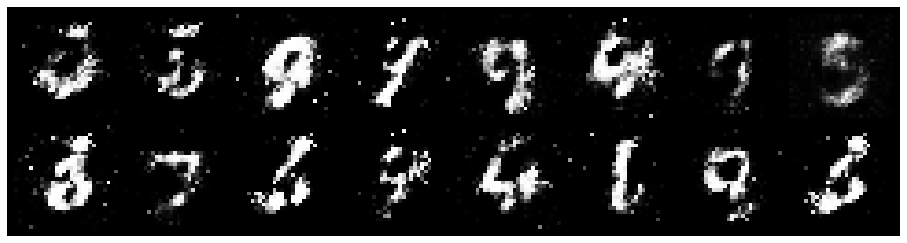

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.7780, Generator Loss: 1.9733
D(x): 0.7313, D(G(z)): 0.2512


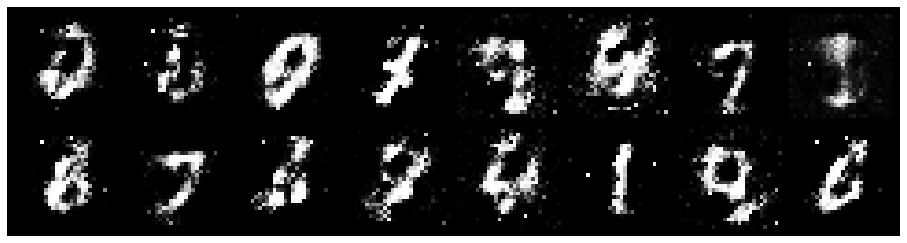

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.6491, Generator Loss: 2.0240
D(x): 0.7596, D(G(z)): 0.2382


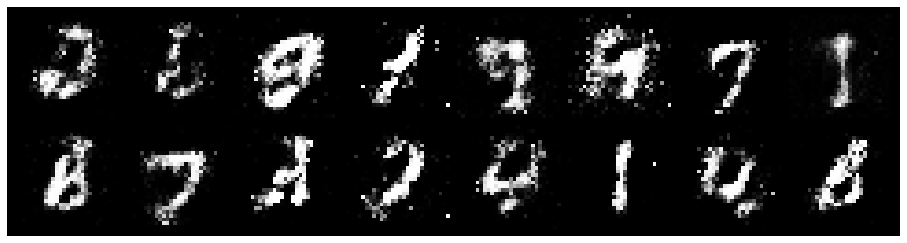

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.6859, Generator Loss: 1.9193
D(x): 0.7687, D(G(z)): 0.2167


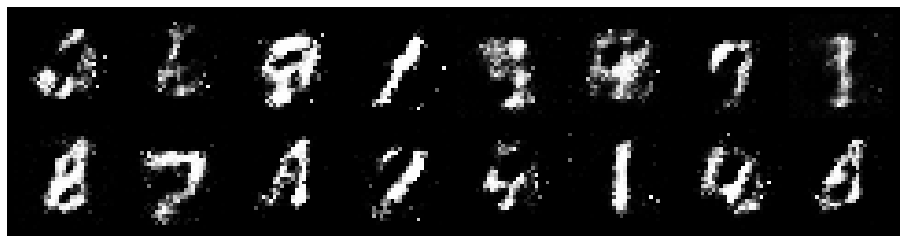

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.8917, Generator Loss: 1.8967
D(x): 0.7628, D(G(z)): 0.3212


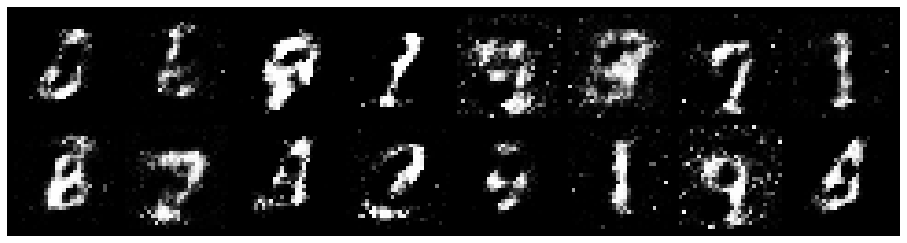

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.8674, Generator Loss: 1.6773
D(x): 0.7328, D(G(z)): 0.2934


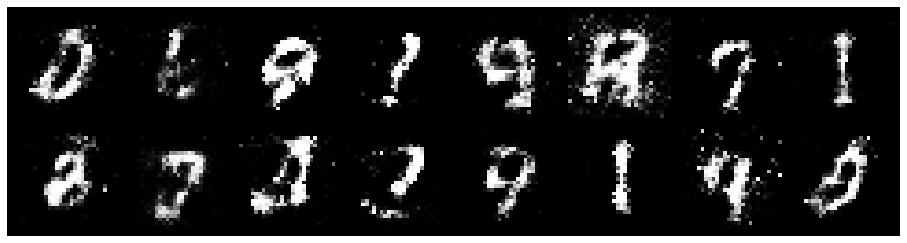

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.7233, Generator Loss: 1.5818
D(x): 0.7399, D(G(z)): 0.2394


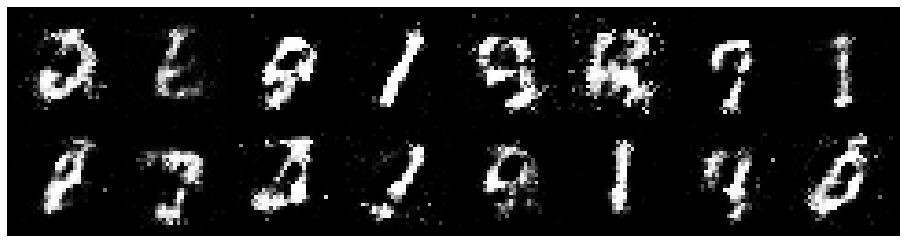

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.6417, Generator Loss: 2.3934
D(x): 0.7652, D(G(z)): 0.2079


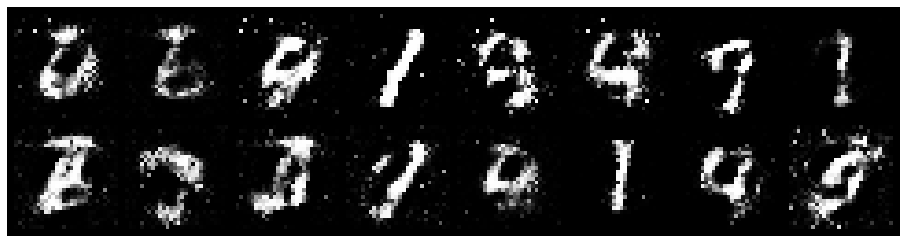

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.7385, Generator Loss: 1.6379
D(x): 0.7929, D(G(z)): 0.3043


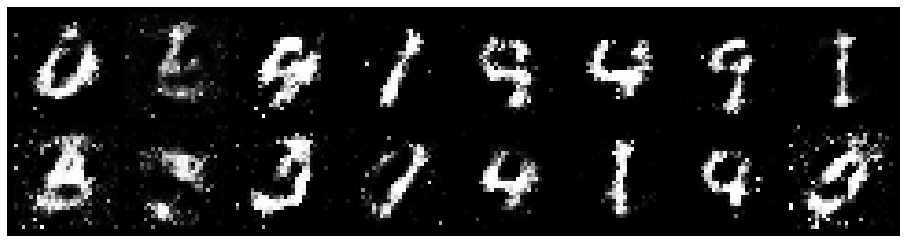

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.7855, Generator Loss: 2.0808
D(x): 0.6795, D(G(z)): 0.1973


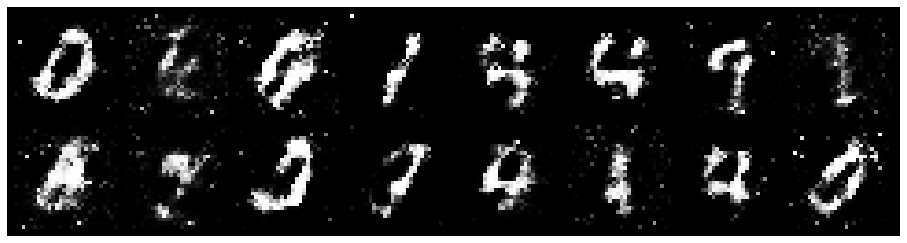

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.4918, Generator Loss: 2.0410
D(x): 0.8144, D(G(z)): 0.1914


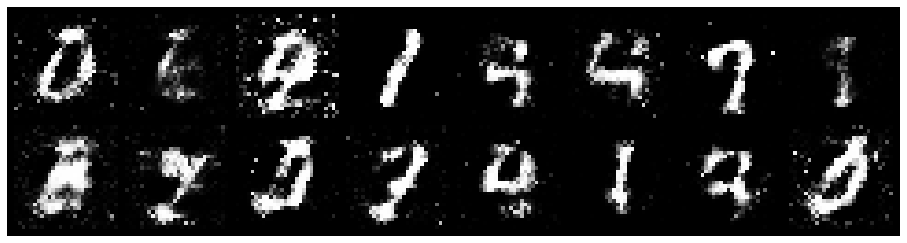

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.6415, Generator Loss: 2.3649
D(x): 0.7186, D(G(z)): 0.1696


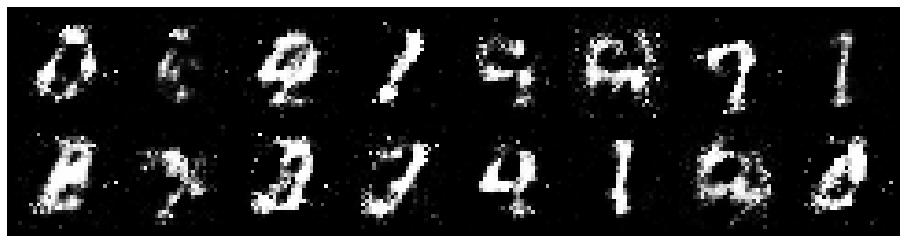

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.6287, Generator Loss: 2.0743
D(x): 0.8061, D(G(z)): 0.2178


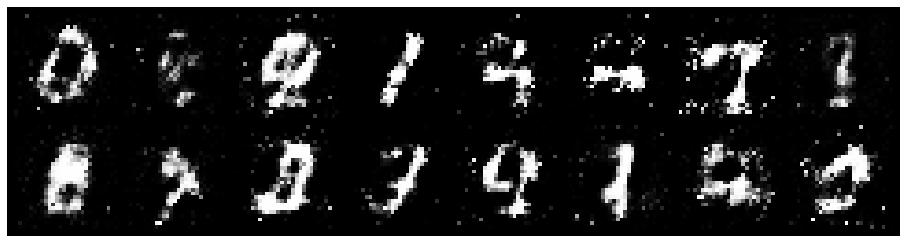

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 1.2221, Generator Loss: 1.6305
D(x): 0.5554, D(G(z)): 0.2756


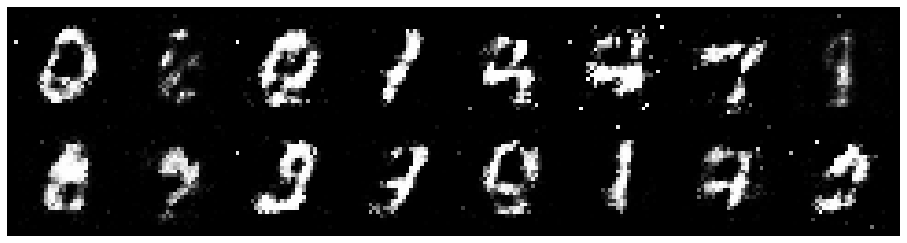

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.9040, Generator Loss: 1.8883
D(x): 0.7166, D(G(z)): 0.2997


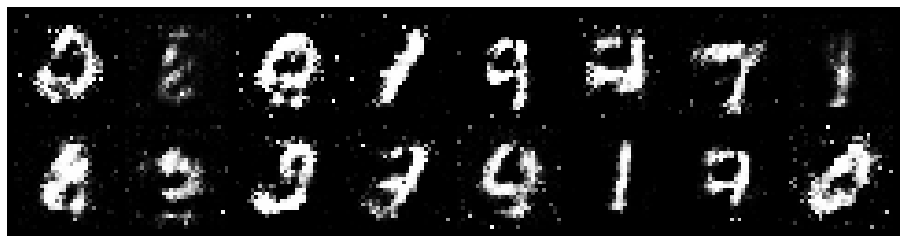

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.9153, Generator Loss: 1.7869
D(x): 0.6973, D(G(z)): 0.3176


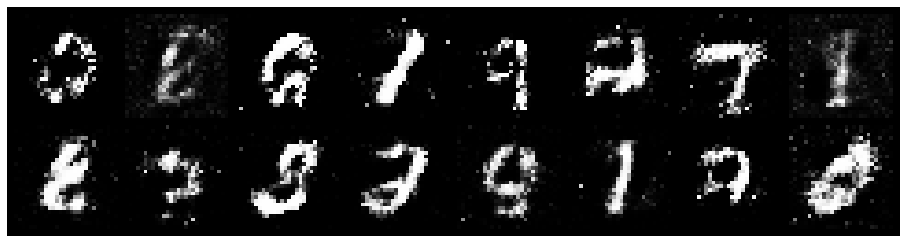

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.7819, Generator Loss: 2.1642
D(x): 0.7711, D(G(z)): 0.2752


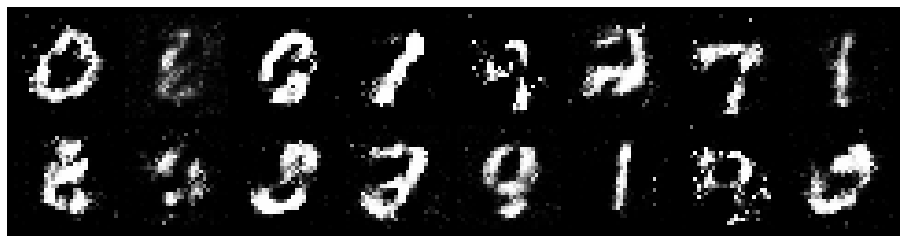

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.8780, Generator Loss: 1.4430
D(x): 0.7270, D(G(z)): 0.3472


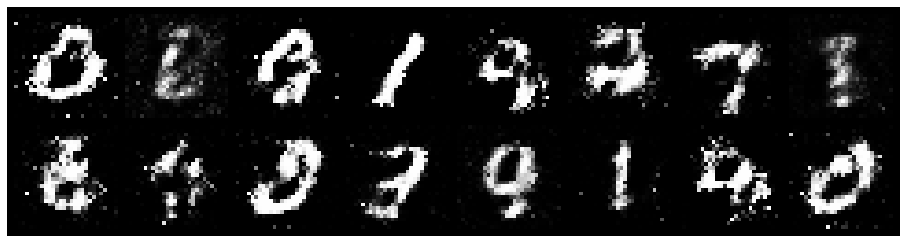

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.8910, Generator Loss: 1.4773
D(x): 0.6633, D(G(z)): 0.2745


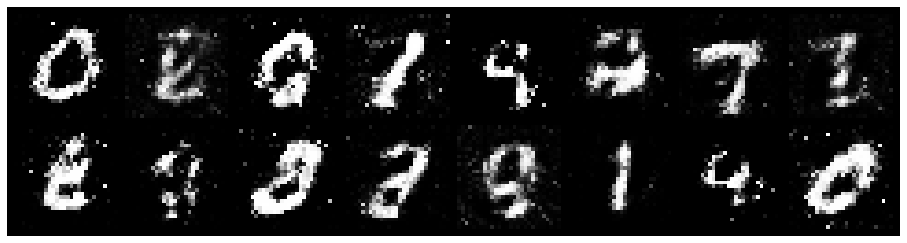

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.7692, Generator Loss: 1.8901
D(x): 0.7900, D(G(z)): 0.3060


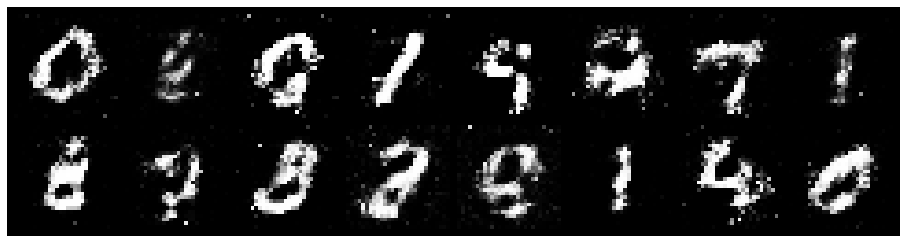

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.9497, Generator Loss: 1.7070
D(x): 0.6968, D(G(z)): 0.2978


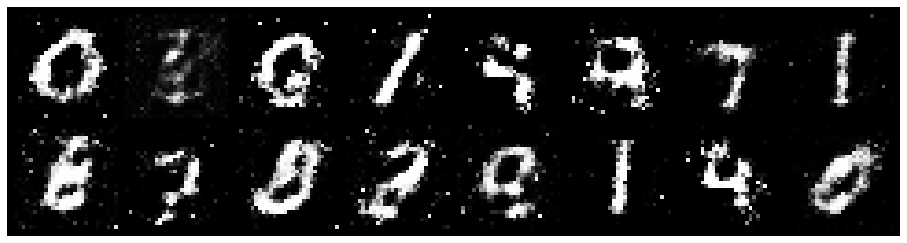

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.8039, Generator Loss: 1.3348
D(x): 0.7761, D(G(z)): 0.3090


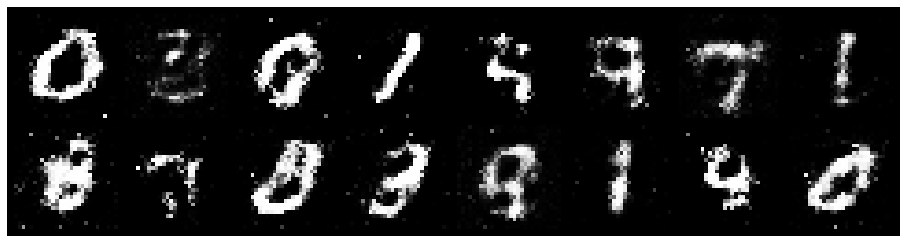

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 1.0203, Generator Loss: 1.6121
D(x): 0.6454, D(G(z)): 0.3148


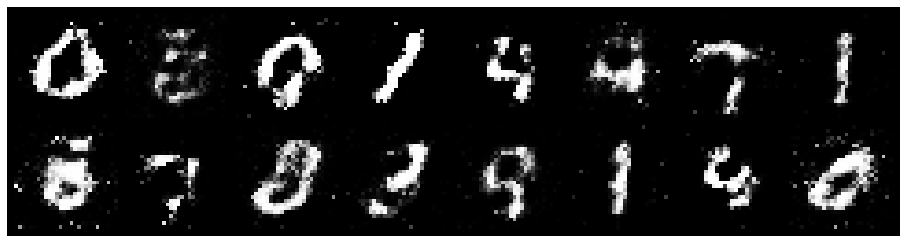

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 1.2172, Generator Loss: 1.5766
D(x): 0.5745, D(G(z)): 0.3232


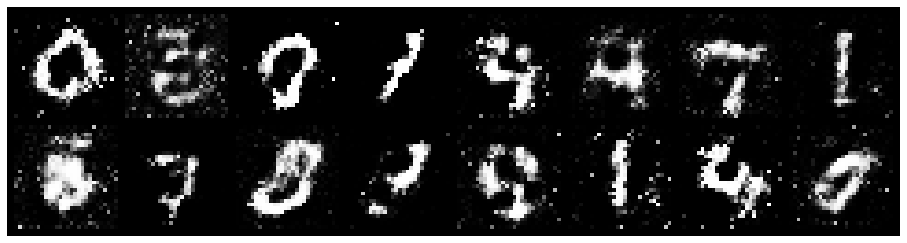

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 0.9163, Generator Loss: 1.3757
D(x): 0.6448, D(G(z)): 0.3081


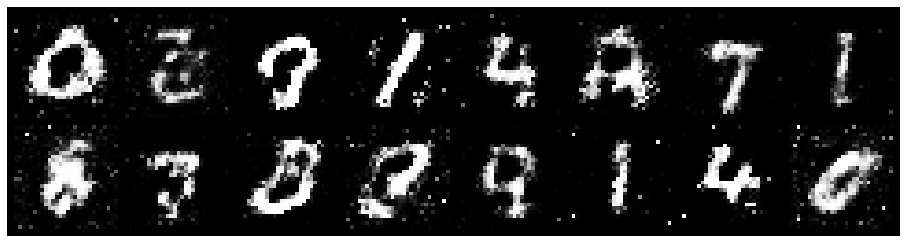

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.9566, Generator Loss: 1.4709
D(x): 0.7313, D(G(z)): 0.3710


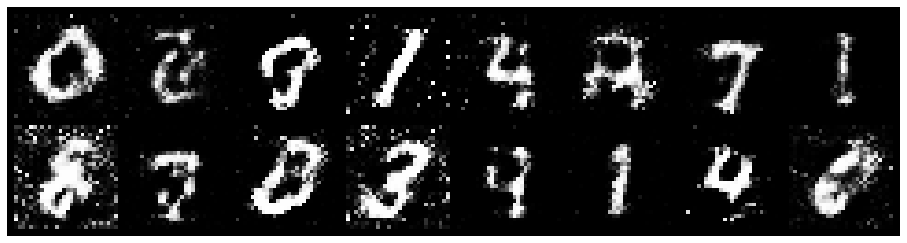

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 0.8097, Generator Loss: 1.5537
D(x): 0.7022, D(G(z)): 0.2713


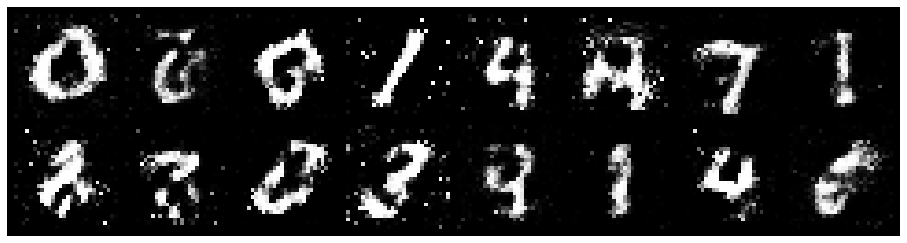

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.8339, Generator Loss: 1.6843
D(x): 0.6888, D(G(z)): 0.2614


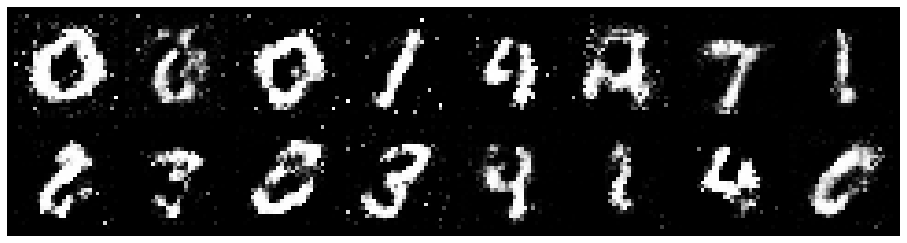

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.8039, Generator Loss: 1.6665
D(x): 0.7990, D(G(z)): 0.3334


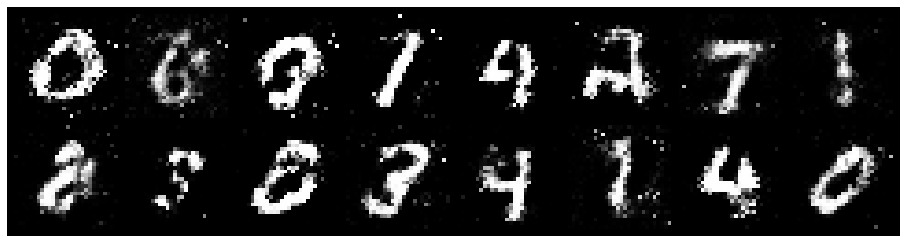

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.7289, Generator Loss: 2.1426
D(x): 0.7460, D(G(z)): 0.2311


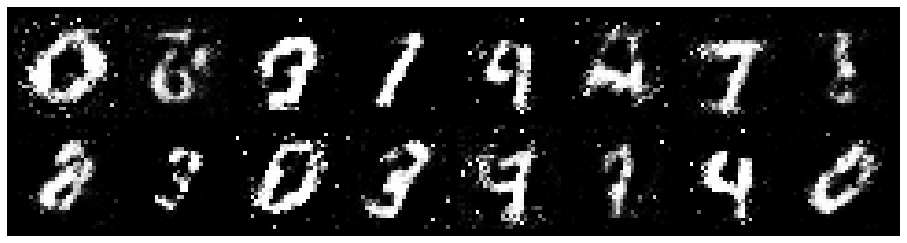

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.9433, Generator Loss: 1.4168
D(x): 0.7376, D(G(z)): 0.3468


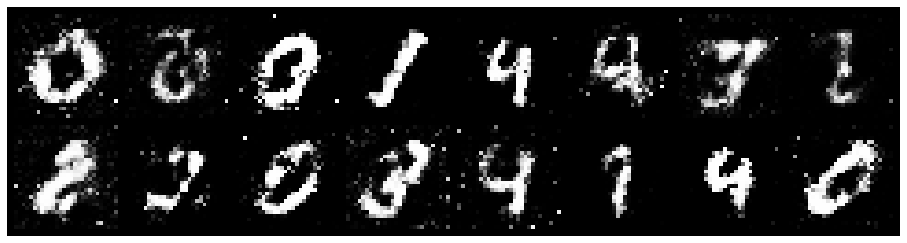

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.8103, Generator Loss: 1.5822
D(x): 0.7377, D(G(z)): 0.3081


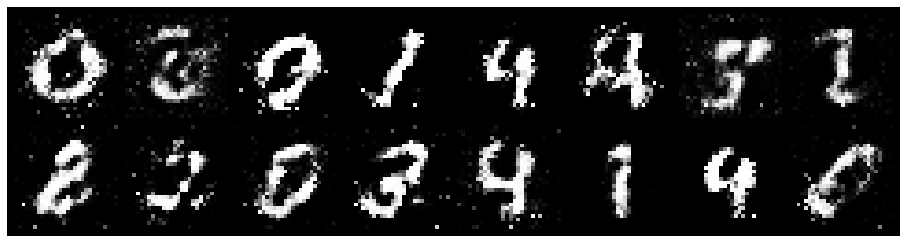

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.9151, Generator Loss: 1.7593
D(x): 0.7410, D(G(z)): 0.3433


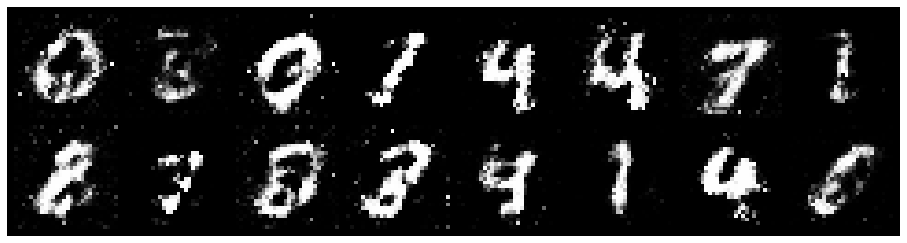

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 0.8397, Generator Loss: 1.2996
D(x): 0.7446, D(G(z)): 0.3048


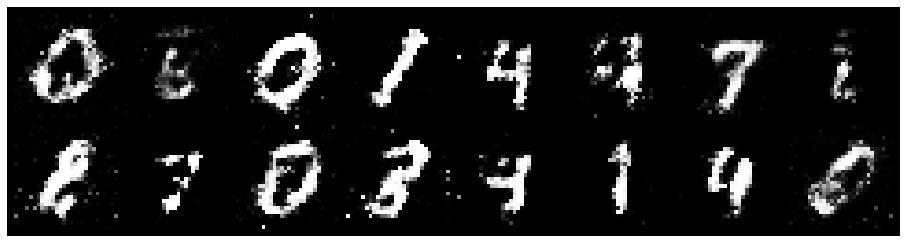

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 0.9878, Generator Loss: 1.5683
D(x): 0.6803, D(G(z)): 0.3110


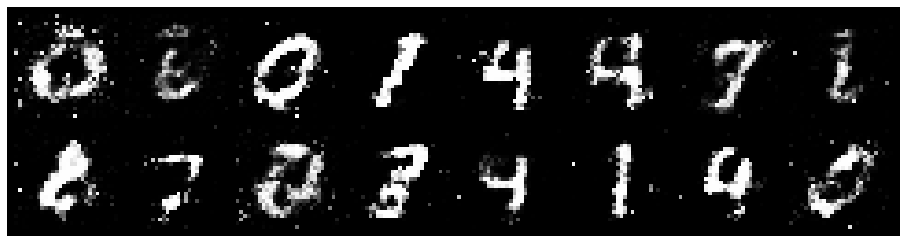

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 0.7348, Generator Loss: 1.7986
D(x): 0.7256, D(G(z)): 0.2265


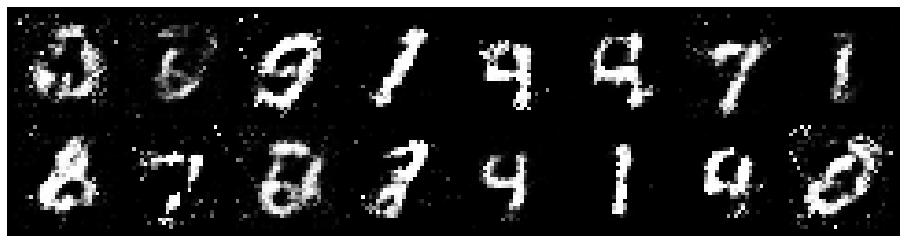

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.7462, Generator Loss: 1.8922
D(x): 0.7236, D(G(z)): 0.2534


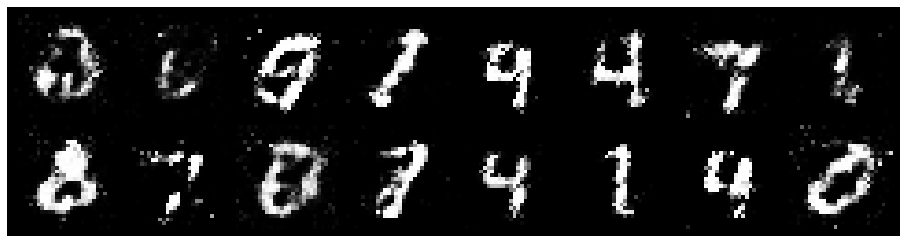

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 0.8560, Generator Loss: 1.3583
D(x): 0.6913, D(G(z)): 0.2802


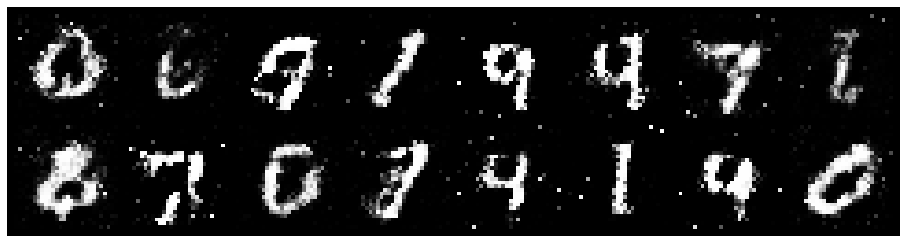

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 1.0196, Generator Loss: 1.4842
D(x): 0.6560, D(G(z)): 0.3186


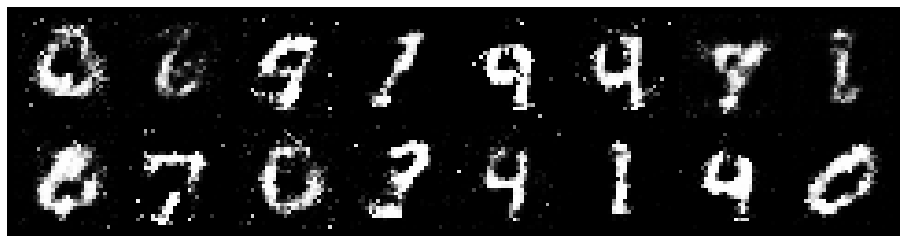

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 0.6844, Generator Loss: 1.8062
D(x): 0.7348, D(G(z)): 0.1899


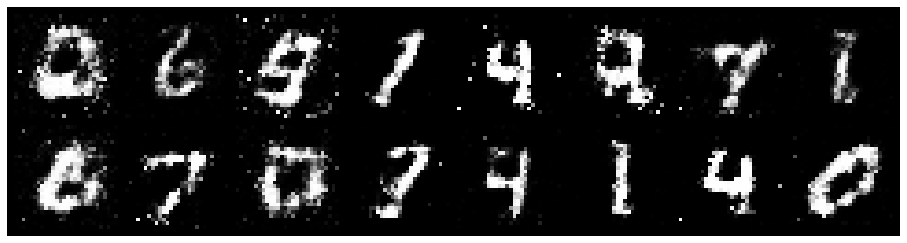

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 1.0224, Generator Loss: 1.3227
D(x): 0.7234, D(G(z)): 0.4075


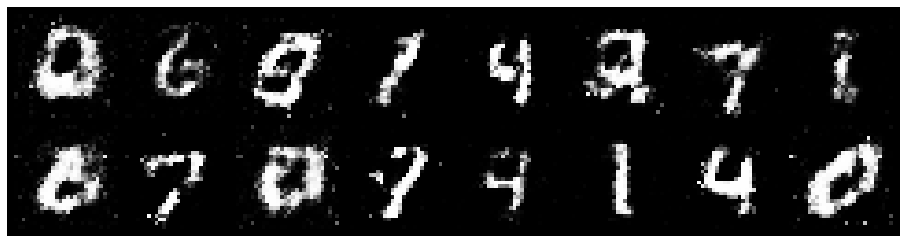

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 1.0683, Generator Loss: 1.7640
D(x): 0.7625, D(G(z)): 0.3655


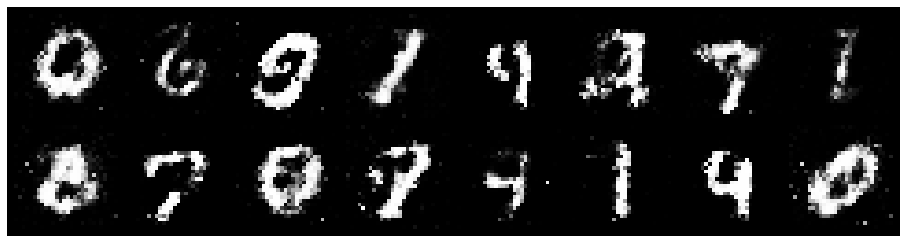

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 0.8172, Generator Loss: 1.4998
D(x): 0.6891, D(G(z)): 0.2730


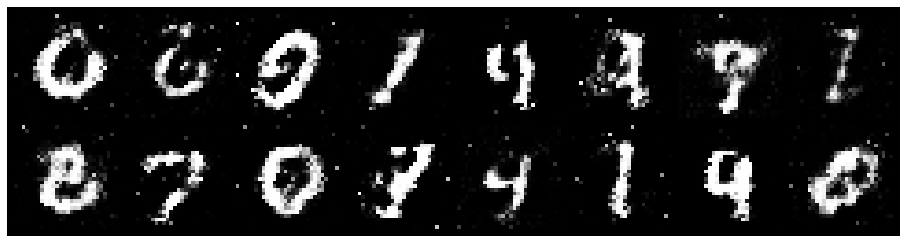

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 0.8494, Generator Loss: 1.8888
D(x): 0.6927, D(G(z)): 0.2420


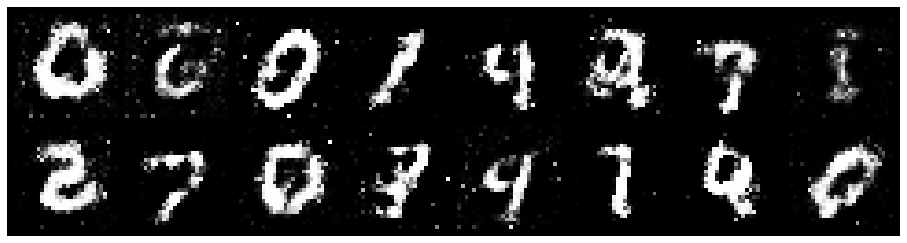

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.8490, Generator Loss: 2.0512
D(x): 0.7410, D(G(z)): 0.2809


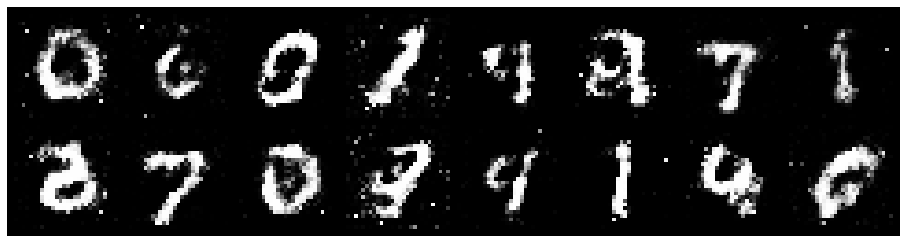

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 0.7737, Generator Loss: 1.8433
D(x): 0.7663, D(G(z)): 0.2653


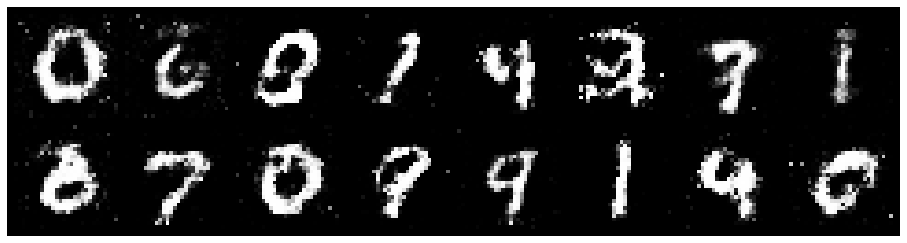

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 0.9698, Generator Loss: 2.1453
D(x): 0.6814, D(G(z)): 0.2491


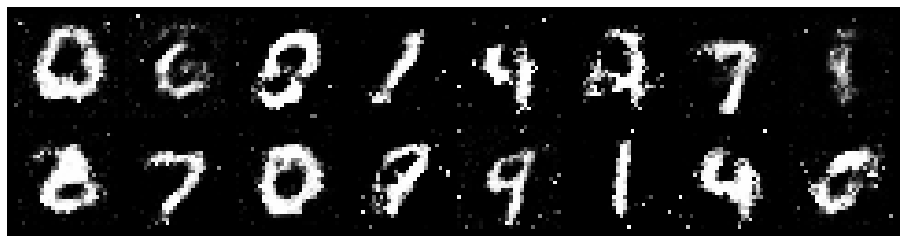

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 0.7894, Generator Loss: 1.4967
D(x): 0.7592, D(G(z)): 0.2820


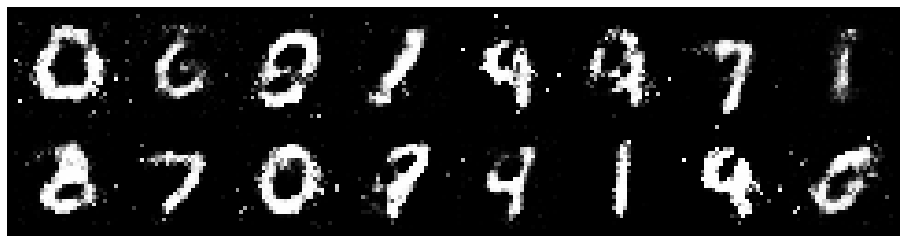

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 0.9164, Generator Loss: 1.4939
D(x): 0.6549, D(G(z)): 0.2940


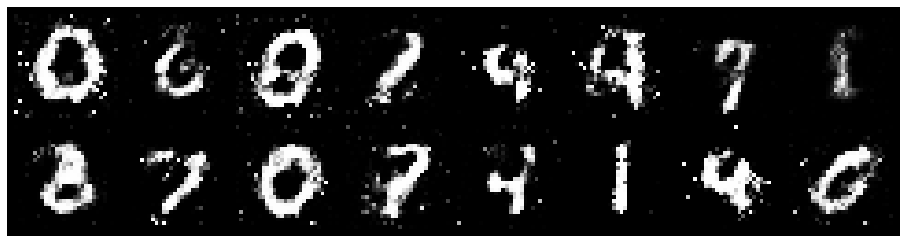

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 1.0102, Generator Loss: 1.6039
D(x): 0.6701, D(G(z)): 0.3036


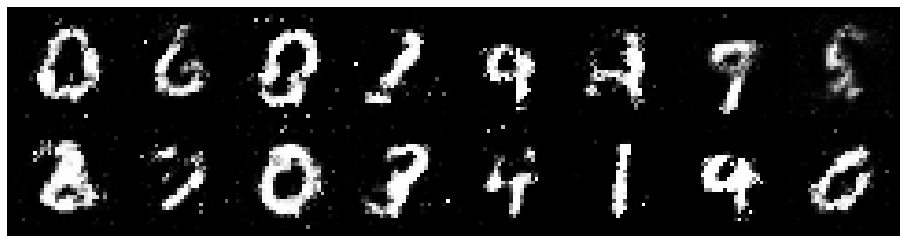

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 1.2015, Generator Loss: 1.1463
D(x): 0.6549, D(G(z)): 0.4271


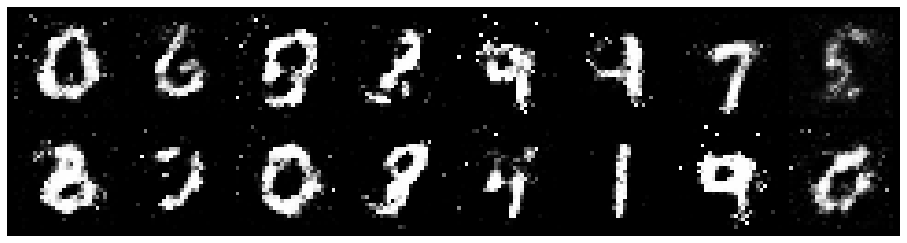

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 1.0177, Generator Loss: 1.2607
D(x): 0.7622, D(G(z)): 0.4105


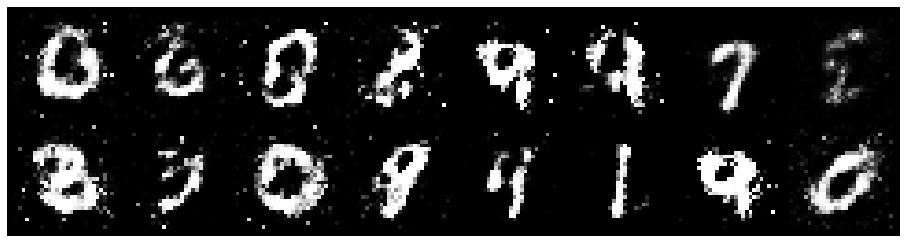

Epoch: [26/200], Batch Num: [200/600]
Discriminator Loss: 1.1568, Generator Loss: 1.2125
D(x): 0.6353, D(G(z)): 0.3879


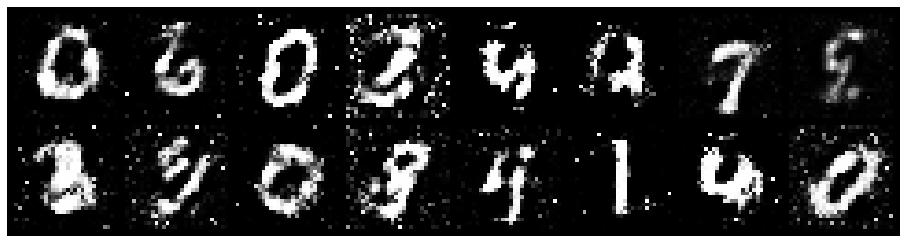

Epoch: [26/200], Batch Num: [300/600]
Discriminator Loss: 1.0701, Generator Loss: 1.2103
D(x): 0.6493, D(G(z)): 0.3688


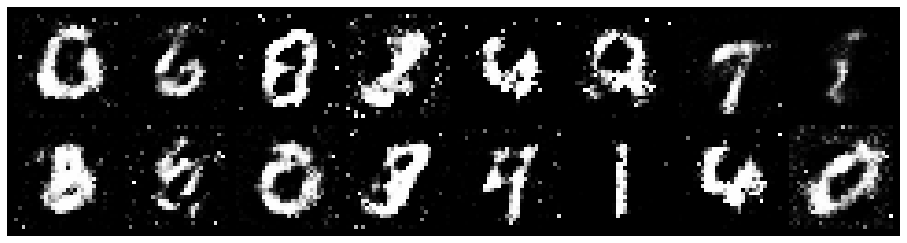

Epoch: [26/200], Batch Num: [400/600]
Discriminator Loss: 0.8832, Generator Loss: 1.8944
D(x): 0.6475, D(G(z)): 0.2205


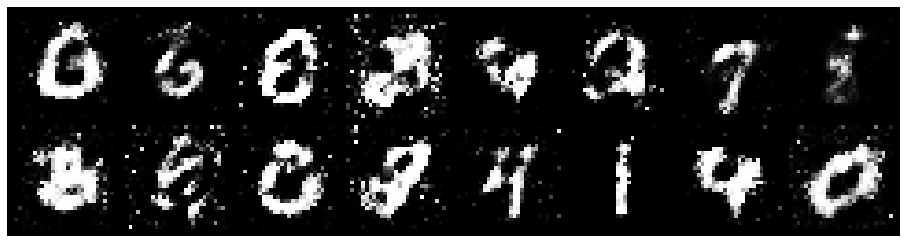

Epoch: [26/200], Batch Num: [500/600]
Discriminator Loss: 1.1913, Generator Loss: 1.2417
D(x): 0.5755, D(G(z)): 0.3460


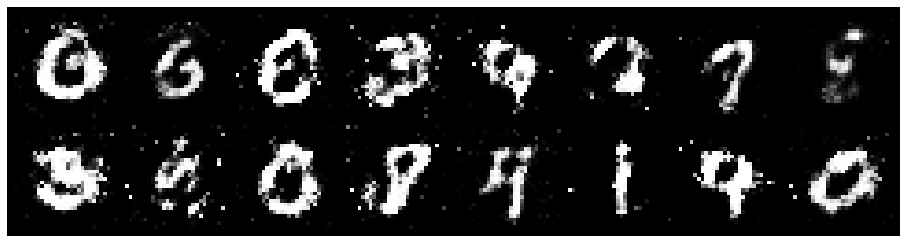

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 1.0439, Generator Loss: 1.5403
D(x): 0.6280, D(G(z)): 0.2681


KeyboardInterrupt: 

In [49]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
#         print(real_batch.shape)
#         print(real_batch.view(real_batch.size(0), 784))
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )